# CyberBattleSim with a defender

Hi everybody, in this quick notebook we gonna to try a CyberBattleSim environment with a defender. 
We will use the default AD environment provided by the framework and we will train a DQN algorithm to attack our network.

Are you ready ? Let's go !

## 1. Environment définition

In [1]:
%matplotlib inline
%matplotlib widget
import matplotlib
import sys
import logging
import gym
import importlib

sys.path.insert(0, '..')

import cyberbattle.agents.baseline.learner as learner
import cyberbattle.agents.baseline.plotting as p
import cyberbattle.agents.baseline.agent_wrapper as w
import cyberbattle.agents.baseline.agent_dql as dqla
import cyberbattle.agents.baseline.agent_randomcredlookup as rca
from cyberbattle.agents.baseline.agent_wrapper import Verbosity
from cyberbattle._env.defender import ScanAndReimageCompromisedMachines
from cyberbattle._env.cyberbattle_env import AttackerGoal, DefenderConstraint

importlib.reload(learner)
importlib.reload(p)
importlib.reload(p)

# let's activate debug messages
logging.basicConfig(stream=sys.stdout, level=logging.ERROR, format="%(levelname)s: %(message)s")

### 1.1 Defender creation

CyberBattleSim provide two defenders ScanAndReimageCompromisedMachines and ExternalRandomEvents.

- **ScanAndReimageCompromisedMachines**: regularly scans a certain number of machines and if it detects a defender (according to a set probability), resets the machine.
- **ExternalRandomEvents**: adds, removes vulnerabilities in the environment randomly and does the same for firewall rules. It's a bit like the default administrator of a rural college.

For this example we will use ScanAndReimageCompromisedMachines.

In [2]:
defender = ScanAndReimageCompromisedMachines(
                               probability=0.6,
                               scan_capacity=2,
                               scan_frequency=5)

### 1.2 Environment constraints

We are now going to choose the objectives for the attacker and the defender.
The agent wins the simulation if the attacker's objective is achieved or if the defender's objective fails.

In [3]:
# The defender have to maintains 80% of machine in security
defender_constraint = DefenderConstraint(
                               maintain_sla=0.80
                           )

# The attacker have to own 100% of machines.
attacker_goal = AttackerGoal(
                               own_atleast=0,
                               own_atleast_percent=1.0
                           )

## 1.3 Environment creation

Let's create our environment. We use the gym.make function to accomplish this task, utilizing a predefined environment named CyberBattleChain. This environment is randomly defined with a fixed number of nodes. For this example, we choose a network of 10 nodes.

In [4]:
cyberbattlechain_defender = gym.make('CyberBattleChain-v0',
                           size=10,
                           attacker_goal=attacker_goal,
                           defender_constraint=defender_constraint,
                           defender_agent=defender)

### 1.4 Training Parameters

We must define parameters to train our DQN agent. These parameters help constrain the agent's learning space.

Each simulation runs for a limited number of iterations; the simulation ends when an agent successfully takes control of the network. We will define **iteration_count** as the maximum number of steps per simulation. Additionally, we need to define **training_episode_count** as the number of simulations to run. The agent improves with each simulation, so the more simulations we run, the better the agent will become.

In [5]:
ep = w.EnvironmentBounds.of_identifiers(
    maximum_total_credentials=22,
    maximum_node_count=22,
    identifiers=cyberbattlechain_defender.identifiers
)

iteration_count = 600
training_episode_count = 100

## 2. Agent training

### 2.1 Agent definition

We create our DQL learning agent using the default hyper-parameters provided by CyberBattleSim :

In [6]:
agent = dqla.DeepQLearnerPolicy(
        ep=ep,
        gamma=0.15,
        replay_memory_size=10000,
        target_update=5,
        batch_size=256,
        learning_rate=0.01)

### 2.2 First training

To illustrate training with graphical rendering, we will execute three training steps with graphical rendering. We cannot perform full training with this capability, as it could crash our environment (yes, it happened to me!).

In [7]:
dql_with_defender = learner.epsilon_greedy_search(
    cyberbattle_gym_env=cyberbattlechain_defender,
    environment_properties=ep,
    learner=agent,
    episode_count=3,
    iteration_count=iteration_count,
    epsilon=0.90,
    render=True,
    epsilon_exponential_decay=5000,
    epsilon_minimum=0.10,
    verbosity=Verbosity.Quiet,
    title="DQL"
)

  Episode 3 ended at t=501 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 4/93 (0.04)
    explore-remote: 15/125 (0.11)
    explore-connect: 2/125 (0.02)
    exploit-local: 13/14 (0.48)
    exploit-remote: 2/56 (0.03)
    exploit-connect: 7/45 (0.13)
  exploit deflected to exploration: 4


,status,properties,local_attacks,remote_attacks
id,,,,
start,owned,[],[ScanExplorerRecentFiles],[]
1_LinuxNode,owned,"[MySql, Ubuntu, nginx/1.10.3]","[ScanExplorerRecentFiles, CrackKeepPassX, Sudo...","[ProbeLinux, ProbeWindows]"
3_LinuxNode,owned,"[MySql, Ubuntu, nginx/1.10.3]","[ScanExplorerRecentFiles, CrackKeepPassX, Sudo...","[ProbeLinux, ProbeWindows]"
6_WindowsNode,owned,"[Windows, Win10, Win10Patched]","[ScanExplorerRecentFiles, CrackKeepPass, Crack...","[ProbeLinux, ProbeWindows]"
7_LinuxNode,owned,"[MySql, Ubuntu, nginx/1.10.3]","[ScanExplorerRecentFiles, CrackKeepPassX, Sudo...","[ProbeLinux, ProbeWindows]"
2_WindowsNode,discovered,NaN,None,"[ProbeLinux, ProbeWindows]"
4_WindowsNode,discovered,NaN,None,"[ProbeLinux, ProbeWindows]"
5_LinuxNode,discovered,NaN,None,"[ProbeLinux, ProbeWindows]"
8_WindowsNode,discovered,NaN,None,"[ProbeLinux, ProbeWindows]"


simulation ended


/home/deemel/Workspace/theo-droid/articles/01_cyber_battle_sim_1/CyberBattleSim/cyberbattle/agents/baseline/plotting.py:177: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



Environment render is really helpfull to understand how the training works. However let's train our agent for real !

### 2.3 Full training

This time we desactivate environment render and train with our previously defined training_episode_count variable.

In [8]:
dql_with_defender = learner.epsilon_greedy_search(
    cyberbattle_gym_env=cyberbattlechain_defender,
    environment_properties=ep,
    learner=agent,
    episode_count=training_episode_count,
    iteration_count=iteration_count,
    epsilon=0.90,
    render=False,
    epsilon_exponential_decay=5000,
    epsilon_minimum=0.10,
    verbosity=Verbosity.Quiet,
    title="DQL"
)

Episode 5|Iteration 227|reward: 1160.0|last_reward_at:  213|Elapsed Time: 0:00:01||
Episode 5|Iteration 227|reward: 1160.0|last_reward_at:  227|Elapsed Time: 0:00:01||
Episode 5|Iteration 232|reward: 1166.0|last_reward_at:  227|Elapsed Time: 0:00:01||
Episode 5|Iteration 232|reward: 1166.0|last_reward_at:  232|Elapsed Time: 0:00:01||
Episode 5|Iteration 236|reward: 6166.0|last_reward_at:  232|Elapsed Time: 0:00:01||
Episode 5|Iteration 236|reward: 6166.0|last_reward_at:  236|Elapsed Time: 0:00:01||


  Episode 5 ended at t=236 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/38 (0.03)
    explore-remote: 13/36 (0.27)
    explore-connect: 1/57 (0.02)
    exploit-local: 16/3 (0.84)
    exploit-remote: 5/10 (0.33)
    exploit-connect: 9/47 (0.16)
  exploit deflected to exploration: 0
  ## Episode: 6/100 'DQL' ϵ=0.6452, γ=0.15, lr=0.01, replaymemory=10000,
batch=256, target_update=5


Episode 6|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 6|Iteration 1|reward:    0.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 6|Iteration 3|reward:   14.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 6|Iteration 3|reward:   14.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 6|Iteration 4|reward:   18.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 6|Iteration 4|reward:   18.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 6|Iteration 7|reward:   20.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 6|Iteration 7|reward:   20.0|last_reward_at:    7|Elapsed Time: 0:00:00||
Episode 6|Iteration 11|reward:  120.0|last_reward_at:    7|Elapsed Time: 0:00:00||
Episode 6|Iteration 11|reward:  120.0|last_reward_at:   11|Elapsed Time: 0:00:00||
Episode 6|Iteration 12|reward:  134.0|last_reward_at:   11|Elapsed Time: 0:00:00||
Episode 6|Iteration 12|reward:  134.0|last_reward_at:   12|Elapsed Time: 0:00:00||
Episode 6|It

  Episode 6 ended at t=111 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/13 (0.13)
    explore-remote: 6/20 (0.23)
    explore-connect: 2/24 (0.08)
    exploit-local: 9/0 (1.00)
    exploit-remote: 3/18 (0.14)
    exploit-connect: 5/9 (0.36)
  exploit deflected to exploration: 0
  ## Episode: 7/100 'DQL' ϵ=0.6333, γ=0.15, lr=0.01, replaymemory=10000,
batch=256, target_update=5


Episode 7|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 7|Iteration 1|reward:   14.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 7|Iteration 1|reward:   14.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 7|Iteration 2|reward:  114.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 7|Iteration 2|reward:  114.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 7|Iteration 3|reward:  128.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 7|Iteration 3|reward:  128.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 7|Iteration 4|reward:  134.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 7|Iteration 4|reward:  134.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 7|Iteration 5|reward:  234.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 7|Iteration 5|reward:  234.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Episode 7|Iteration 8|reward:  248.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Episode 7|Iterat

  Episode 7 ended at t=61 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/9 (0.18)
    explore-remote: 4/6 (0.40)
    explore-connect: 0/12 (0.00)
    exploit-local: 6/0 (1.00)
    exploit-remote: 1/15 (0.06)
    exploit-connect: 5/1 (0.83)
  exploit deflected to exploration: 0
  ## Episode: 8/100 'DQL' ϵ=0.6268, γ=0.15, lr=0.01, replaymemory=10000,
batch=256, target_update=5


Episode 8|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 8|Iteration 1|reward:   14.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 8|Iteration 1|reward:   14.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 8|Iteration 3|reward:   18.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 8|Iteration 3|reward:   18.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 8|Iteration 16|reward:  118.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 8|Iteration 16|reward:  118.0|last_reward_at:   16|Elapsed Time: 0:00:00||
Episode 8|Iteration 17|reward:  132.0|last_reward_at:   16|Elapsed Time: 0:00:00||
Episode 8|Iteration 17|reward:  132.0|last_reward_at:   17|Elapsed Time: 0:00:00||
Episode 8|Iteration 23|reward:  232.0|last_reward_at:   17|Elapsed Time: 0:00:00||
Episode 8|Iteration 23|reward:  232.0|last_reward_at:   23|Elapsed Time: 0:00:00||
Episode 8|Iteration 26|reward:  246.0|last_reward_at:   23|Elapsed Time: 0:00:00||
Episode 8

  Episode 8 ended at t=106 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 4/15 (0.21)
    explore-remote: 6/20 (0.23)
    explore-connect: 0/19 (0.00)
    exploit-local: 7/0 (1.00)
    exploit-remote: 4/11 (0.27)
    exploit-connect: 6/14 (0.30)
  exploit deflected to exploration: 1
  ## Episode: 9/100 'DQL' ϵ=0.6157, γ=0.15, lr=0.01, replaymemory=10000,
batch=256, target_update=5


Episode 9|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 9|Iteration 1|reward:    0.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 9|Iteration 4|reward:   14.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 9|Iteration 4|reward:   14.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 9|Iteration 6|reward:  114.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 9|Iteration 6|reward:  114.0|last_reward_at:    6|Elapsed Time: 0:00:00||
Episode 9|Iteration 7|reward:  128.0|last_reward_at:    6|Elapsed Time: 0:00:00||
Episode 9|Iteration 7|reward:  128.0|last_reward_at:    7|Elapsed Time: 0:00:00||
Episode 9|Iteration 8|reward:  228.0|last_reward_at:    7|Elapsed Time: 0:00:00||
Episode 9|Iteration 8|reward:  228.0|last_reward_at:    8|Elapsed Time: 0:00:00||
Episode 9|Iteration 9|reward:  230.0|last_reward_at:    8|Elapsed Time: 0:00:00||
Episode 9|Iteration 9|reward:  230.0|last_reward_at:    9|Elapsed Time: 0:00:00||
Episode 9|Iterat

  Episode 9 ended at t=226 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 3/39 (0.07)
    explore-remote: 10/39 (0.20)
    explore-connect: 0/51 (0.00)
    exploit-local: 8/0 (1.00)
    exploit-remote: 4/27 (0.13)
    exploit-connect: 7/38 (0.16)
  exploit deflected to exploration: 0
  ## Episode: 10/100 'DQL' ϵ=0.5930, γ=0.15, lr=0.01, replaymemory=10000,
batch=256, target_update=5


Episode 10|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 10|Iteration 1|reward:    0.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 10|Iteration 3|reward:   14.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 10|Iteration 3|reward:   14.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 10|Iteration 4|reward:   18.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 10|Iteration 4|reward:   18.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 10|Iteration 11|reward:   20.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 10|Iteration 11|reward:   20.0|last_reward_at:   11|Elapsed Time: 0:00:00||
Episode 10|Iteration 31|reward:   20.0|last_reward_at:   11|Elapsed Time: 0:00:00||
Episode 10|Iteration 43|reward:  120.0|last_reward_at:   11|Elapsed Time: 0:00:00||
Episode 10|Iteration 43|reward:  120.0|last_reward_at:   43|Elapsed Time: 0:00:00||
Episode 10|Iteration 44|reward:  134.0|last_reward_at:   43|Elapsed Time: 0:00:00|

  Episode 10 ended at t=241 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/23 (0.08)
    explore-remote: 7/40 (0.15)
    explore-connect: 1/56 (0.02)
    exploit-local: 7/0 (1.00)
    exploit-remote: 4/67 (0.06)
    exploit-connect: 7/27 (0.21)
  exploit deflected to exploration: 2
  ## Episode: 11/100 'DQL' ϵ=0.5698, γ=0.15, lr=0.01, replaymemory=10000,
batch=256, target_update=5


Episode 11|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 11|Iteration 1|reward:    0.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 11|Iteration 2|reward:   14.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 11|Iteration 2|reward:   14.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 11|Iteration 4|reward:   16.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 11|Iteration 4|reward:   16.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 11|Iteration 5|reward:  116.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 11|Iteration 5|reward:  116.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Episode 11|Iteration 7|reward:  130.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Episode 11|Iteration 7|reward:  130.0|last_reward_at:    7|Elapsed Time: 0:00:00||
Episode 11|Iteration 8|reward:  230.0|last_reward_at:    7|Elapsed Time: 0:00:00||
Episode 11|Iteration 8|reward:  230.0|last_reward_at:    8|Elapsed Time: 0:00:00||
Epis

  Episode 11 ended at t=36 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/1 (0.50)
    explore-remote: 5/10 (0.33)
    explore-connect: 1/4 (0.20)
    exploit-local: 6/0 (1.00)
    exploit-remote: 1/0 (1.00)
    exploit-connect: 7/0 (1.00)
  exploit deflected to exploration: 0
  ## Episode: 12/100 'DQL' ϵ=0.5664, γ=0.15, lr=0.01, replaymemory=10000,
batch=256, target_update=5


Episode 12|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 12|Iteration 1|reward:    0.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 12|Iteration 7|reward:   14.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 12|Iteration 7|reward:   14.0|last_reward_at:    7|Elapsed Time: 0:00:00||
Episode 12|Iteration 13|reward:  114.0|last_reward_at:    7|Elapsed Time: 0:00:00||
Episode 12|Iteration 13|reward:  114.0|last_reward_at:   13|Elapsed Time: 0:00:00||
Episode 12|Iteration 14|reward:  116.0|last_reward_at:   13|Elapsed Time: 0:00:00||
Episode 12|Iteration 14|reward:  116.0|last_reward_at:   14|Elapsed Time: 0:00:00||
Episode 12|Iteration 15|reward:  130.0|last_reward_at:   14|Elapsed Time: 0:00:00||
Episode 12|Iteration 15|reward:  130.0|last_reward_at:   15|Elapsed Time: 0:00:00||
Episode 12|Iteration 16|reward:  138.0|last_reward_at:   15|Elapsed Time: 0:00:00||
Episode 12|Iteration 16|reward:  138.0|last_reward_at:   16|Elapsed Time: 0:00:0

  Episode 12 ended at t=56 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/5 (0.29)
    explore-remote: 9/8 (0.53)
    explore-connect: 0/10 (0.00)
    exploit-local: 10/0 (1.00)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 9/3 (0.75)
  exploit deflected to exploration: 2
  ## Episode: 13/100 'DQL' ϵ=0.5612, γ=0.15, lr=0.01, replaymemory=10000,
batch=256, target_update=5


Episode 13|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 13|Iteration 1|reward:   14.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 13|Iteration 1|reward:   14.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 13|Iteration 2|reward:  114.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 13|Iteration 2|reward:  114.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 13|Iteration 4|reward:  128.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 13|Iteration 4|reward:  128.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 13|Iteration 5|reward:  134.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 13|Iteration 5|reward:  134.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Episode 13|Iteration 10|reward:  136.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Episode 13|Iteration 10|reward:  136.0|last_reward_at:   10|Elapsed Time: 0:00:00||
Episode 13|Iteration 14|reward:  144.0|last_reward_at:   10|Elapsed Time: 0:00:00||
E

  Episode 13 ended at t=126 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/16 (0.06)
    explore-remote: 5/22 (0.19)
    explore-connect: 2/28 (0.07)
    exploit-local: 10/0 (1.00)
    exploit-remote: 2/23 (0.08)
    exploit-connect: 9/8 (0.53)
  exploit deflected to exploration: 0
  ## Episode: 14/100 'DQL' ϵ=0.5497, γ=0.15, lr=0.01, replaymemory=10000,
batch=256, target_update=5


Episode 14|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 14|Iteration 1|reward:   14.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 14|Iteration 1|reward:   14.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 14|Iteration 6|reward:   16.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 14|Iteration 6|reward:   16.0|last_reward_at:    6|Elapsed Time: 0:00:00||
Episode 14|Iteration 7|reward:   20.0|last_reward_at:    6|Elapsed Time: 0:00:00||
Episode 14|Iteration 7|reward:   20.0|last_reward_at:    7|Elapsed Time: 0:00:00||
Episode 14|Iteration 23|reward:   20.0|last_reward_at:    7|Elapsed Time: 0:00:00||
Episode 14|Iteration 34|reward:  120.0|last_reward_at:    7|Elapsed Time: 0:00:00||
Episode 14|Iteration 34|reward:  120.0|last_reward_at:   34|Elapsed Time: 0:00:00||
Episode 14|Iteration 37|reward:  134.0|last_reward_at:   34|Elapsed Time: 0:00:00||
Episode 14|Iteration 37|reward:  134.0|last_reward_at:   37|Elapsed Time: 0:00:00||

  Episode 14 ended at t=131 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/10 (0.09)
    explore-remote: 3/22 (0.12)
    explore-connect: 0/31 (0.00)
    exploit-local: 9/0 (1.00)
    exploit-remote: 3/20 (0.13)
    exploit-connect: 9/23 (0.28)
  exploit deflected to exploration: 0
  ## Episode: 15/100 'DQL' ϵ=0.5381, γ=0.15, lr=0.01, replaymemory=10000,
batch=256, target_update=5


Episode 15|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 15|Iteration 1|reward:    0.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 15|Iteration 3|reward:   14.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 15|Iteration 3|reward:   14.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 15|Iteration 4|reward:   18.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 15|Iteration 4|reward:   18.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 15|Iteration 6|reward:  118.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 15|Iteration 6|reward:  118.0|last_reward_at:    6|Elapsed Time: 0:00:00||
Episode 15|Iteration 7|reward:  132.0|last_reward_at:    6|Elapsed Time: 0:00:00||
Episode 15|Iteration 7|reward:  132.0|last_reward_at:    7|Elapsed Time: 0:00:00||
Episode 15|Iteration 8|reward:  232.0|last_reward_at:    7|Elapsed Time: 0:00:00||
Episode 15|Iteration 8|reward:  232.0|last_reward_at:    8|Elapsed Time: 0:00:00||
Epis

  Episode 15 ended at t=86 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/6 (0.14)
    explore-remote: 6/9 (0.40)
    explore-connect: 1/23 (0.04)
    exploit-local: 12/0 (1.00)
    exploit-remote: 2/5 (0.29)
    exploit-connect: 10/11 (0.48)
  exploit deflected to exploration: 0
  ## Episode: 16/100 'DQL' ϵ=0.5306, γ=0.15, lr=0.01, replaymemory=10000,
batch=256, target_update=5


Episode 16|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 16|Iteration 1|reward:   14.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 16|Iteration 1|reward:   14.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 16|Iteration 2|reward:  114.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 16|Iteration 2|reward:  114.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 16|Iteration 3|reward:  116.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 16|Iteration 3|reward:  116.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 16|Iteration 4|reward:  118.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 16|Iteration 4|reward:  118.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 16|Iteration 6|reward:  129.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 16|Iteration 6|reward:  129.0|last_reward_at:    6|Elapsed Time: 0:00:00||
Episode 16|Iteration 11|reward:  138.0|last_reward_at:    6|Elapsed Time: 0:00:00||
Epi

  Episode 16 ended at t=66 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/5 (0.29)
    explore-remote: 5/7 (0.42)
    explore-connect: 1/17 (0.06)
    exploit-local: 6/0 (1.00)
    exploit-remote: 0/12 (0.00)
    exploit-connect: 6/5 (0.55)
  exploit deflected to exploration: 0
  ## Episode: 17/100 'DQL' ϵ=0.5250, γ=0.15, lr=0.01, replaymemory=10000,
batch=256, target_update=5


Episode 17|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 17|Iteration 1|reward:    0.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 17|Iteration 6|reward:   14.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 17|Iteration 6|reward:   14.0|last_reward_at:    6|Elapsed Time: 0:00:00||
Episode 17|Iteration 7|reward:   16.0|last_reward_at:    6|Elapsed Time: 0:00:00||
Episode 17|Iteration 7|reward:   16.0|last_reward_at:    7|Elapsed Time: 0:00:00||
Episode 17|Iteration 8|reward:  116.0|last_reward_at:    7|Elapsed Time: 0:00:00||
Episode 17|Iteration 8|reward:  116.0|last_reward_at:    8|Elapsed Time: 0:00:00||
Episode 17|Iteration 10|reward:  118.0|last_reward_at:    8|Elapsed Time: 0:00:00||
Episode 17|Iteration 10|reward:  118.0|last_reward_at:   10|Elapsed Time: 0:00:00||
Episode 17|Iteration 14|reward:  132.0|last_reward_at:   10|Elapsed Time: 0:00:00||
Episode 17|Iteration 14|reward:  132.0|last_reward_at:   14|Elapsed Time: 0:00:00||


  Episode 17 ended at t=36 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/5 (0.17)
    explore-remote: 4/7 (0.36)
    explore-connect: 0/6 (0.00)
    exploit-local: 6/0 (1.00)
    exploit-remote: 1/0 (1.00)
    exploit-connect: 5/1 (0.83)
  exploit deflected to exploration: 3
  ## Episode: 18/100 'DQL' ϵ=0.5219, γ=0.15, lr=0.01, replaymemory=10000,
batch=256, target_update=5


Episode 18|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 18|Iteration 1|reward:    0.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 18|Iteration 4|reward:   14.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 18|Iteration 4|reward:   14.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 18|Iteration 5|reward:   16.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 18|Iteration 5|reward:   16.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Episode 18|Iteration 8|reward:   20.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Episode 18|Iteration 8|reward:   20.0|last_reward_at:    8|Elapsed Time: 0:00:00||
Episode 18|Iteration 19|reward:  120.0|last_reward_at:    8|Elapsed Time: 0:00:00||
Episode 18|Iteration 19|reward:  120.0|last_reward_at:   19|Elapsed Time: 0:00:00||
Episode 18|Iteration 20|reward:  134.0|last_reward_at:   19|Elapsed Time: 0:00:00||
Episode 18|Iteration 20|reward:  134.0|last_reward_at:   20|Elapsed Time: 0:00:00||


  Episode 18 ended at t=36 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/2 (0.33)
    explore-remote: 3/7 (0.30)
    explore-connect: 1/7 (0.12)
    exploit-local: 5/0 (1.00)
    exploit-remote: 1/5 (0.17)
    exploit-connect: 4/0 (1.00)
  exploit deflected to exploration: 1
  ## Episode: 19/100 'DQL' ϵ=0.5189, γ=0.15, lr=0.01, replaymemory=10000,
batch=256, target_update=5


Episode 19|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 19|Iteration 1|reward:    0.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 19|Iteration 2|reward:   14.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 19|Iteration 2|reward:   14.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 19|Iteration 3|reward:  114.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 19|Iteration 3|reward:  114.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 19|Iteration 4|reward:  128.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 19|Iteration 4|reward:  128.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 19|Iteration 6|reward:  134.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 19|Iteration 6|reward:  134.0|last_reward_at:    6|Elapsed Time: 0:00:00||
Episode 19|Iteration 15|reward:  142.0|last_reward_at:    6|Elapsed Time: 0:00:00||
Episode 19|Iteration 15|reward:  142.0|last_reward_at:   15|Elapsed Time: 0:00:00||
Ep

  Episode 19 ended at t=311 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 5/38 (0.12)
    explore-remote: 7/54 (0.11)
    explore-connect: 1/53 (0.02)
    exploit-local: 4/0 (1.00)
    exploit-remote: 5/102 (0.05)
    exploit-connect: 5/37 (0.12)
  exploit deflected to exploration: 0
  ## Episode: 20/100 'DQL' ϵ=0.4936, γ=0.15, lr=0.01, replaymemory=10000,
batch=256, target_update=5


Episode 20|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 20|Iteration 1|reward:   14.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 20|Iteration 1|reward:   14.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 20|Iteration 2|reward:   16.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 20|Iteration 2|reward:   16.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 20|Iteration 3|reward:  116.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 20|Iteration 3|reward:  116.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 20|Iteration 6|reward:  130.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 20|Iteration 6|reward:  130.0|last_reward_at:    6|Elapsed Time: 0:00:00||
Episode 20|Iteration 7|reward:  136.0|last_reward_at:    6|Elapsed Time: 0:00:00||
Episode 20|Iteration 7|reward:  136.0|last_reward_at:    7|Elapsed Time: 0:00:00||
Episode 20|Iteration 8|reward:  236.0|last_reward_at:    7|Elapsed Time: 0:00:00||
Epis

  Episode 20 ended at t=156 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 4/17 (0.19)
    explore-remote: 3/15 (0.17)
    explore-connect: 2/31 (0.06)
    exploit-local: 10/0 (1.00)
    exploit-remote: 6/46 (0.12)
    exploit-connect: 8/14 (0.36)
  exploit deflected to exploration: 0
  ## Episode: 21/100 'DQL' ϵ=0.4815, γ=0.15, lr=0.01, replaymemory=10000,
batch=256, target_update=5


Episode 21|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 21|Iteration 1|reward:   14.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 21|Iteration 1|reward:   14.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 21|Iteration 2|reward:   18.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 21|Iteration 2|reward:   18.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 21|Iteration 3|reward:   20.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 21|Iteration 3|reward:   20.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 21|Iteration 23|reward:   20.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 21|Iteration 38|reward:   20.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 21|Iteration 54|reward:   20.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 21|Iteration 69|reward:   20.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 21|Iteration 84|reward:   20.0|last_reward_at:    3|Elapsed Time: 0:00:00||

  Episode 21 ended at t=241 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 3/17 (0.15)
    explore-remote: 5/40 (0.11)
    explore-connect: 1/42 (0.02)
    exploit-local: 8/0 (1.00)
    exploit-remote: 9/72 (0.11)
    exploit-connect: 7/37 (0.16)
  exploit deflected to exploration: 0
  ## Episode: 22/100 'DQL' ϵ=0.4636, γ=0.15, lr=0.01, replaymemory=10000,
batch=256, target_update=5


Episode 22|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 22|Iteration 1|reward:    0.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 22|Iteration 4|reward:   14.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 22|Iteration 4|reward:   14.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 22|Iteration 6|reward:   16.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 22|Iteration 6|reward:   16.0|last_reward_at:    6|Elapsed Time: 0:00:00||
Episode 22|Iteration 7|reward:  116.0|last_reward_at:    6|Elapsed Time: 0:00:00||
Episode 22|Iteration 7|reward:  116.0|last_reward_at:    7|Elapsed Time: 0:00:00||
Episode 22|Iteration 8|reward:  130.0|last_reward_at:    7|Elapsed Time: 0:00:00||
Episode 22|Iteration 8|reward:  130.0|last_reward_at:    8|Elapsed Time: 0:00:00||
Episode 22|Iteration 10|reward:  230.0|last_reward_at:    8|Elapsed Time: 0:00:00||
Episode 22|Iteration 10|reward:  230.0|last_reward_at:   10|Elapsed Time: 0:00:00||
Ep

  Episode 22 ended at t=81 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/12 (0.00)
    explore-remote: 5/6 (0.45)
    explore-connect: 0/11 (0.00)
    exploit-local: 9/0 (1.00)
    exploit-remote: 9/11 (0.45)
    exploit-connect: 9/9 (0.50)
  exploit deflected to exploration: 1
  ## Episode: 23/100 'DQL' ϵ=0.4577, γ=0.15, lr=0.01, replaymemory=10000,
batch=256, target_update=5


Episode 23|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 23|Iteration 1|reward:   14.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 23|Iteration 1|reward:   14.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 23|Iteration 2|reward:   16.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 23|Iteration 2|reward:   16.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 23|Iteration 3|reward:  116.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 23|Iteration 3|reward:  116.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 23|Iteration 4|reward:  130.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 23|Iteration 4|reward:  130.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 23|Iteration 5|reward:  230.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 23|Iteration 5|reward:  230.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Episode 23|Iteration 7|reward:  236.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Epis

  Episode 23 ended at t=36 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/0 (NaN)
    explore-remote: 3/2 (0.60)
    explore-connect: 0/3 (0.00)
    exploit-local: 12/0 (1.00)
    exploit-remote: 2/3 (0.40)
    exploit-connect: 11/0 (1.00)
  exploit deflected to exploration: 0
  ## Episode: 24/100 'DQL' ϵ=0.4552, γ=0.15, lr=0.01, replaymemory=10000,
batch=256, target_update=5


Episode 24|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 24|Iteration 1|reward:   14.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 24|Iteration 1|reward:   14.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 24|Iteration 2|reward:   18.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 24|Iteration 2|reward:   18.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 24|Iteration 3|reward:   20.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 24|Iteration 3|reward:   20.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 24|Iteration 23|reward:   20.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 24|Iteration 38|reward:   20.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 24|Iteration 40|reward:  120.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 24|Iteration 40|reward:  120.0|last_reward_at:   40|Elapsed Time: 0:00:00||
Episode 24|Iteration 44|reward:  134.0|last_reward_at:   40|Elapsed Time: 0:00:00||

  Episode 24 ended at t=131 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/8 (0.20)
    explore-remote: 6/23 (0.21)
    explore-connect: 1/23 (0.04)
    exploit-local: 9/0 (1.00)
    exploit-remote: 6/40 (0.13)
    exploit-connect: 6/7 (0.46)
  exploit deflected to exploration: 0
  ## Episode: 25/100 'DQL' ϵ=0.4460, γ=0.15, lr=0.01, replaymemory=10000,
batch=256, target_update=5


Episode 25|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 25|Iteration 1|reward:   14.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 25|Iteration 1|reward:   14.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 25|Iteration 2|reward:  114.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 25|Iteration 2|reward:  114.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 25|Iteration 4|reward:  128.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 25|Iteration 4|reward:  128.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 25|Iteration 8|reward:  134.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 25|Iteration 8|reward:  134.0|last_reward_at:    8|Elapsed Time: 0:00:00||
Episode 25|Iteration 9|reward:  234.0|last_reward_at:    8|Elapsed Time: 0:00:00||
Episode 25|Iteration 9|reward:  234.0|last_reward_at:    9|Elapsed Time: 0:00:00||
Episode 25|Iteration 11|reward:  248.0|last_reward_at:    9|Elapsed Time: 0:00:00||
Epi

  Episode 25 ended at t=586 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 5/41 (0.11)
    explore-remote: 10/92 (0.10)
    explore-connect: 1/92 (0.01)
    exploit-local: 16/27 (0.37)
    exploit-remote: 10/254 (0.04)
    exploit-connect: 10/28 (0.26)
  exploit deflected to exploration: 1
  ## Episode: 26/100 'DQL' ϵ=0.4077, γ=0.15, lr=0.01, replaymemory=10000,
batch=256, target_update=5


Episode 26|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 26|Iteration 1|reward:   14.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 26|Iteration 1|reward:   14.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 26|Iteration 8|reward:   18.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 26|Iteration 8|reward:   18.0|last_reward_at:    8|Elapsed Time: 0:00:00||
Episode 26|Iteration 23|reward:   18.0|last_reward_at:    8|Elapsed Time: 0:00:00||
Episode 26|Iteration 24|reward:   20.0|last_reward_at:    8|Elapsed Time: 0:00:00||
Episode 26|Iteration 24|reward:   20.0|last_reward_at:   24|Elapsed Time: 0:00:00||
Episode 26|Iteration 34|reward:  120.0|last_reward_at:   24|Elapsed Time: 0:00:00||
Episode 26|Iteration 34|reward:  120.0|last_reward_at:   34|Elapsed Time: 0:00:00||
Episode 26|Iteration 54|reward:  120.0|last_reward_at:   34|Elapsed Time: 0:00:00||
Episode 26|Iteration 54|reward:  134.0|last_reward_at:   34|Elapsed Time: 0:00:00

  Episode 26 ended at t=221 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/15 (0.06)
    explore-remote: 4/34 (0.11)
    explore-connect: 2/38 (0.05)
    exploit-local: 11/7 (0.61)
    exploit-remote: 5/83 (0.06)
    exploit-connect: 10/11 (0.48)
  exploit deflected to exploration: 5
  ## Episode: 27/100 'DQL' ϵ=0.3944, γ=0.15, lr=0.01, replaymemory=10000,
batch=256, target_update=5


Episode 27|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 27|Iteration 1|reward:    0.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 27|Iteration 2|reward:   14.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 27|Iteration 2|reward:   14.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 27|Iteration 3|reward:   16.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 27|Iteration 3|reward:   16.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 27|Iteration 4|reward:  116.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 27|Iteration 4|reward:  116.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 27|Iteration 5|reward:  130.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 27|Iteration 5|reward:  130.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Episode 27|Iteration 6|reward:  230.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Episode 27|Iteration 6|reward:  230.0|last_reward_at:    6|Elapsed Time: 0:00:00||
Epis

  Episode 27 ended at t=391 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/33 (0.06)
    explore-remote: 6/60 (0.09)
    explore-connect: 0/66 (0.00)
    exploit-local: 10/34 (0.23)
    exploit-remote: 8/125 (0.06)
    exploit-connect: 7/40 (0.15)
  exploit deflected to exploration: 19
  ## Episode: 28/100 'DQL' ϵ=0.3723, γ=0.15, lr=0.01, replaymemory=10000,
batch=256, target_update=5


Episode 28|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 28|Iteration 1|reward:   14.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 28|Iteration 1|reward:   14.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 28|Iteration 3|reward:   18.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 28|Iteration 3|reward:   18.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 28|Iteration 10|reward:   20.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 28|Iteration 10|reward:   20.0|last_reward_at:   10|Elapsed Time: 0:00:00||
Episode 28|Iteration 31|reward:   20.0|last_reward_at:   10|Elapsed Time: 0:00:00||
Episode 28|Iteration 46|reward:   20.0|last_reward_at:   10|Elapsed Time: 0:00:00||
Episode 28|Iteration 61|reward:   20.0|last_reward_at:   10|Elapsed Time: 0:00:00||
Episode 28|Iteration 76|reward:   20.0|last_reward_at:   10|Elapsed Time: 0:00:00||
Episode 28|Iteration 92|reward:   20.0|last_reward_at:   10|Elapsed Time: 0:00:00

  Episode 28 ended at t=296 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/10 (0.09)
    explore-remote: 3/51 (0.06)
    explore-connect: 1/55 (0.02)
    exploit-local: 7/8 (0.47)
    exploit-remote: 5/131 (0.04)
    exploit-connect: 5/19 (0.21)
  exploit deflected to exploration: 13
  ## Episode: 29/100 'DQL' ϵ=0.3566, γ=0.15, lr=0.01, replaymemory=10000,
batch=256, target_update=5


Episode 29|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 29|Iteration 1|reward:   14.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 29|Iteration 1|reward:   14.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 29|Iteration 2|reward:   18.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 29|Iteration 2|reward:   18.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 29|Iteration 5|reward:  118.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 29|Iteration 5|reward:  118.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Episode 29|Iteration 6|reward:  132.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Episode 29|Iteration 6|reward:  132.0|last_reward_at:    6|Elapsed Time: 0:00:00||
Episode 29|Iteration 11|reward:  232.0|last_reward_at:    6|Elapsed Time: 0:00:00||
Episode 29|Iteration 11|reward:  232.0|last_reward_at:   11|Elapsed Time: 0:00:00||
Episode 29|Iteration 13|reward:  246.0|last_reward_at:   11|Elapsed Time: 0:00:00||
E

  Episode 29 ended at t=31 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/3 (0.25)
    explore-remote: 4/2 (0.67)
    explore-connect: 0/4 (0.00)
    exploit-local: 8/0 (1.00)
    exploit-remote: 0/2 (0.00)
    exploit-connect: 7/0 (1.00)
  exploit deflected to exploration: 0
  ## Episode: 30/100 'DQL' ϵ=0.3550, γ=0.15, lr=0.01, replaymemory=10000,
batch=256, target_update=5


Episode 30|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 30|Iteration 1|reward:    0.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 30|Iteration 2|reward:   14.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 30|Iteration 2|reward:   14.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 30|Iteration 4|reward:   18.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 30|Iteration 4|reward:   18.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 30|Iteration 5|reward:   20.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 30|Iteration 5|reward:   20.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Episode 30|Iteration 22|reward:  120.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Episode 30|Iteration 22|reward:  120.0|last_reward_at:   22|Elapsed Time: 0:00:00||
Episode 30|Iteration 29|reward:  134.0|last_reward_at:   22|Elapsed Time: 0:00:00||
Episode 30|Iteration 29|reward:  134.0|last_reward_at:   29|Elapsed Time: 0:00:00||


  Episode 30 ended at t=56 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/3 (0.00)
    explore-remote: 4/15 (0.21)
    explore-connect: 1/12 (0.08)
    exploit-local: 8/0 (1.00)
    exploit-remote: 2/3 (0.40)
    exploit-connect: 7/1 (0.88)
  exploit deflected to exploration: 7
  ## Episode: 31/100 'DQL' ϵ=0.3522, γ=0.15, lr=0.01, replaymemory=10000,
batch=256, target_update=5


Episode 31|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 31|Iteration 1|reward:   14.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 31|Iteration 1|reward:   14.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 31|Iteration 2|reward:   18.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 31|Iteration 2|reward:   18.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 31|Iteration 3|reward:   20.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 31|Iteration 3|reward:   20.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 31|Iteration 22|reward:  120.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 31|Iteration 22|reward:  120.0|last_reward_at:   22|Elapsed Time: 0:00:00||
Episode 31|Iteration 23|reward:  134.0|last_reward_at:   22|Elapsed Time: 0:00:00||
Episode 31|Iteration 23|reward:  134.0|last_reward_at:   23|Elapsed Time: 0:00:00||
Episode 31|Iteration 24|reward:  234.0|last_reward_at:   23|Elapsed Time: 0:00:00||

  Episode 31 ended at t=226 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/16 (0.06)
    explore-remote: 2/26 (0.07)
    explore-connect: 1/25 (0.04)
    exploit-local: 7/21 (0.25)
    exploit-remote: 11/90 (0.11)
    exploit-connect: 5/21 (0.19)
  exploit deflected to exploration: 1
  ## Episode: 32/100 'DQL' ϵ=0.3411, γ=0.15, lr=0.01, replaymemory=10000,
batch=256, target_update=5


Episode 32|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 32|Iteration 1|reward:   14.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 32|Iteration 1|reward:   14.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 32|Iteration 2|reward:   18.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 32|Iteration 2|reward:   18.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 32|Iteration 14|reward:   20.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 32|Iteration 14|reward:   20.0|last_reward_at:   14|Elapsed Time: 0:00:00||
Episode 32|Iteration 18|reward:  120.0|last_reward_at:   14|Elapsed Time: 0:00:00||
Episode 32|Iteration 18|reward:  120.0|last_reward_at:   18|Elapsed Time: 0:00:00||
Episode 32|Iteration 19|reward:  131.0|last_reward_at:   18|Elapsed Time: 0:00:00||
Episode 32|Iteration 19|reward:  131.0|last_reward_at:   19|Elapsed Time: 0:00:00||
Episode 32|Iteration 21|reward:  139.0|last_reward_at:   19|Elapsed Time: 0:00:00

  Episode 32 ended at t=326 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 3/20 (0.13)
    explore-remote: 3/52 (0.05)
    explore-connect: 1/55 (0.02)
    exploit-local: 10/10 (0.50)
    exploit-remote: 10/126 (0.07)
    exploit-connect: 10/26 (0.28)
  exploit deflected to exploration: 11
  ## Episode: 33/100 'DQL' ϵ=0.3258, γ=0.15, lr=0.01, replaymemory=10000,
batch=256, target_update=5


Episode 33|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 33|Iteration 1|reward:   14.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 33|Iteration 1|reward:   14.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 33|Iteration 2|reward:   16.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 33|Iteration 2|reward:   16.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 33|Iteration 3|reward:   20.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 33|Iteration 3|reward:   20.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 33|Iteration 16|reward:   20.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 33|Iteration 26|reward:  120.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 33|Iteration 26|reward:  120.0|last_reward_at:   26|Elapsed Time: 0:00:00||
Episode 33|Iteration 27|reward:  134.0|last_reward_at:   26|Elapsed Time: 0:00:00||
Episode 33|Iteration 27|reward:  134.0|last_reward_at:   27|Elapsed Time: 0:00:00||

  Episode 33 ended at t=46 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/0 (1.00)
    explore-remote: 1/6 (0.14)
    explore-connect: 1/7 (0.12)
    exploit-local: 8/0 (1.00)
    exploit-remote: 1/12 (0.08)
    exploit-connect: 8/0 (1.00)
  exploit deflected to exploration: 0
  ## Episode: 34/100 'DQL' ϵ=0.3238, γ=0.15, lr=0.01, replaymemory=10000,
batch=256, target_update=5


Episode 34|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 34|Iteration 1|reward:   14.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 34|Iteration 1|reward:   14.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 34|Iteration 2|reward:   18.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 34|Iteration 2|reward:   18.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 34|Iteration 6|reward:   20.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 34|Iteration 6|reward:   20.0|last_reward_at:    6|Elapsed Time: 0:00:00||
Episode 34|Iteration 23|reward:   20.0|last_reward_at:    6|Elapsed Time: 0:00:00||
Episode 34|Iteration 38|reward:   20.0|last_reward_at:    6|Elapsed Time: 0:00:00||
Episode 34|Iteration 42|reward:  120.0|last_reward_at:    6|Elapsed Time: 0:00:00||
Episode 34|Iteration 42|reward:  120.0|last_reward_at:   42|Elapsed Time: 0:00:00||
Episode 34|Iteration 43|reward:  134.0|last_reward_at:   42|Elapsed Time: 0:00:00||

  Episode 34 ended at t=106 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/7 (0.00)
    explore-remote: 6/7 (0.46)
    explore-connect: 0/14 (0.00)
    exploit-local: 13/1 (0.93)
    exploit-remote: 9/33 (0.21)
    exploit-connect: 11/5 (0.69)
  exploit deflected to exploration: 2
  ## Episode: 35/100 'DQL' ϵ=0.3191, γ=0.15, lr=0.01, replaymemory=10000,
batch=256, target_update=5


Episode 35|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 35|Iteration 1|reward:   14.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 35|Iteration 1|reward:   14.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 35|Iteration 2|reward:   16.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 35|Iteration 2|reward:   16.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 35|Iteration 3|reward:  116.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 35|Iteration 3|reward:  116.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 35|Iteration 4|reward:  130.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 35|Iteration 4|reward:  130.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 35|Iteration 6|reward:  230.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 35|Iteration 6|reward:  230.0|last_reward_at:    6|Elapsed Time: 0:00:00||
Episode 35|Iteration 10|reward:  241.0|last_reward_at:    6|Elapsed Time: 0:00:00||
Epi

  Episode 35 ended at t=316 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/23 (0.08)
    explore-remote: 5/28 (0.15)
    explore-connect: 0/37 (0.00)
    exploit-local: 14/24 (0.37)
    exploit-remote: 12/125 (0.09)
    exploit-connect: 11/35 (0.24)
  exploit deflected to exploration: 2
  ## Episode: 36/100 'DQL' ϵ=0.3057, γ=0.15, lr=0.01, replaymemory=10000,
batch=256, target_update=5


Episode 36|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 36|Iteration 1|reward:   14.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 36|Iteration 1|reward:   14.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 36|Iteration 5|reward:   18.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 36|Iteration 5|reward:   18.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Episode 36|Iteration 7|reward:   20.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Episode 36|Iteration 7|reward:   20.0|last_reward_at:    7|Elapsed Time: 0:00:00||
Episode 36|Iteration 19|reward:  120.0|last_reward_at:    7|Elapsed Time: 0:00:00||
Episode 36|Iteration 19|reward:  120.0|last_reward_at:   19|Elapsed Time: 0:00:00||
Episode 36|Iteration 21|reward:  134.0|last_reward_at:   19|Elapsed Time: 0:00:00||
Episode 36|Iteration 21|reward:  134.0|last_reward_at:   21|Elapsed Time: 0:00:00||
Episode 36|Iteration 22|reward:  234.0|last_reward_at:   21|Elapsed Time: 0:00:00||

  Episode 36 ended at t=56 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 4/1 (0.80)
    explore-remote: 2/6 (0.25)
    explore-connect: 0/7 (0.00)
    exploit-local: 10/0 (1.00)
    exploit-remote: 4/7 (0.36)
    exploit-connect: 11/4 (0.73)
  exploit deflected to exploration: 0
  ## Episode: 37/100 'DQL' ϵ=0.3034, γ=0.15, lr=0.01, replaymemory=10000,
batch=256, target_update=5


Episode 37|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 37|Iteration 1|reward:    0.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 37|Iteration 2|reward:   14.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 37|Iteration 2|reward:   14.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 37|Iteration 3|reward:  114.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 37|Iteration 3|reward:  114.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 37|Iteration 4|reward:  128.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 37|Iteration 4|reward:  128.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 37|Iteration 5|reward:  228.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 37|Iteration 5|reward:  228.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Episode 37|Iteration 7|reward:  242.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Episode 37|Iteration 7|reward:  242.0|last_reward_at:    7|Elapsed Time: 0:00:00||
Epis

  Episode 37 ended at t=101 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/5 (0.00)
    explore-remote: 3/15 (0.17)
    explore-connect: 1/14 (0.07)
    exploit-local: 12/0 (1.00)
    exploit-remote: 3/33 (0.08)
    exploit-connect: 10/5 (0.67)
  exploit deflected to exploration: 9
  ## Episode: 38/100 'DQL' ϵ=0.2993, γ=0.15, lr=0.01, replaymemory=10000,
batch=256, target_update=5


Episode 38|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 38|Iteration 1|reward:   14.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 38|Iteration 1|reward:   14.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 38|Iteration 3|reward:   16.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 38|Iteration 3|reward:   16.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 38|Iteration 4|reward:  116.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 38|Iteration 4|reward:  116.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 38|Iteration 5|reward:  130.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 38|Iteration 5|reward:  130.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Episode 38|Iteration 6|reward:  230.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Episode 38|Iteration 6|reward:  230.0|last_reward_at:    6|Elapsed Time: 0:00:00||
Episode 38|Iteration 7|reward:  244.0|last_reward_at:    6|Elapsed Time: 0:00:00||
Epis

  Episode 38 ended at t=26 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/1 (0.00)
    explore-remote: 1/0 (1.00)
    explore-connect: 0/4 (0.00)
    exploit-local: 9/1 (0.90)
    exploit-remote: 1/0 (1.00)
    exploit-connect: 9/0 (1.00)
  exploit deflected to exploration: 0
  ## Episode: 39/100 'DQL' ϵ=0.2983, γ=0.15, lr=0.01, replaymemory=10000,
batch=256, target_update=5


Episode 39|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 39|Iteration 1|reward:   14.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 39|Iteration 1|reward:   14.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 39|Iteration 2|reward:  114.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 39|Iteration 2|reward:  114.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 39|Iteration 3|reward:  128.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 39|Iteration 3|reward:  128.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 39|Iteration 4|reward:  228.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 39|Iteration 4|reward:  228.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 39|Iteration 5|reward:  242.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 39|Iteration 5|reward:  242.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Episode 39|Iteration 6|reward:  342.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Epis

  Episode 39 stopped at t=600 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/36 (0.03)
    explore-remote: 4/57 (0.07)
    explore-connect: 0/63 (0.00)
    exploit-local: 15/55 (0.21)
    exploit-remote: 16/304 (0.05)
    exploit-connect: 11/38 (0.22)
  exploit deflected to exploration: 10
  ## Episode: 40/100 'DQL' ϵ=0.2758, γ=0.15, lr=0.01, replaymemory=10000,
batch=256, target_update=5


Episode 40|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 40|Iteration 1|reward:   14.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 40|Iteration 1|reward:   14.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 40|Iteration 2|reward:  114.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 40|Iteration 2|reward:  114.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 40|Iteration 3|reward:  128.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 40|Iteration 3|reward:  128.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 40|Iteration 4|reward:  228.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 40|Iteration 4|reward:  228.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 40|Iteration 5|reward:  242.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 40|Iteration 5|reward:  242.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Episode 40|Iteration 6|reward:  342.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Epis

  Episode 40 ended at t=31 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/2 (0.00)
    explore-remote: 2/0 (1.00)
    explore-connect: 0/1 (0.00)
    exploit-local: 9/0 (1.00)
    exploit-remote: 3/2 (0.60)
    exploit-connect: 9/3 (0.75)
  exploit deflected to exploration: 1
  ## Episode: 41/100 'DQL' ϵ=0.2748, γ=0.15, lr=0.01, replaymemory=10000,
batch=256, target_update=5


Episode 41|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 41|Iteration 1|reward:   14.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 41|Iteration 1|reward:   14.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 41|Iteration 2|reward:  114.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 41|Iteration 2|reward:  114.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 41|Iteration 3|reward:  128.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 41|Iteration 3|reward:  128.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 41|Iteration 5|reward:  136.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 41|Iteration 5|reward:  136.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Episode 41|Iteration 8|reward:  138.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Episode 41|Iteration 8|reward:  138.0|last_reward_at:    8|Elapsed Time: 0:00:00||
Episode 41|Iteration 9|reward:  144.0|last_reward_at:    8|Elapsed Time: 0:00:00||
Epis

  Episode 41 ended at t=276 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/12 (0.14)
    explore-remote: 4/37 (0.10)
    explore-connect: 1/37 (0.03)
    exploit-local: 12/13 (0.48)
    exploit-remote: 3/130 (0.02)
    exploit-connect: 11/14 (0.44)
  exploit deflected to exploration: 12
  ## Episode: 42/100 'DQL' ϵ=0.2654, γ=0.15, lr=0.01, replaymemory=10000,
batch=256, target_update=5


Episode 42|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 42|Iteration 1|reward:   14.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 42|Iteration 1|reward:   14.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 42|Iteration 2|reward:  114.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 42|Iteration 2|reward:  114.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 42|Iteration 3|reward:  128.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 42|Iteration 3|reward:  128.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 42|Iteration 4|reward:  228.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 42|Iteration 4|reward:  228.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 42|Iteration 5|reward:  242.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 42|Iteration 5|reward:  242.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Episode 42|Iteration 6|reward:  342.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Epis

  Episode 42 ended at t=26 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/1 (0.50)
    explore-remote: 0/0 (NaN)
    explore-connect: 1/1 (0.50)
    exploit-local: 8/0 (1.00)
    exploit-remote: 2/4 (0.33)
    exploit-connect: 6/2 (0.75)
  exploit deflected to exploration: 0
  ## Episode: 43/100 'DQL' ϵ=0.2645, γ=0.15, lr=0.01, replaymemory=10000,
batch=256, target_update=5


Episode 43|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 43|Iteration 1|reward:   14.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 43|Iteration 1|reward:   14.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 43|Iteration 2|reward:  114.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 43|Iteration 2|reward:  114.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 43|Iteration 3|reward:  128.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 43|Iteration 3|reward:  128.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 43|Iteration 4|reward:  228.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 43|Iteration 4|reward:  228.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 43|Iteration 6|reward:  242.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 43|Iteration 6|reward:  242.0|last_reward_at:    6|Elapsed Time: 0:00:00||
Episode 43|Iteration 7|reward:  342.0|last_reward_at:    6|Elapsed Time: 0:00:00||
Epis

  Episode 43 ended at t=16 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/0 (NaN)
    explore-remote: 0/0 (NaN)
    explore-connect: 0/2 (0.00)
    exploit-local: 5/0 (1.00)
    exploit-remote: 4/1 (0.80)
    exploit-connect: 4/0 (1.00)
  exploit deflected to exploration: 0
  ## Episode: 44/100 'DQL' ϵ=0.2640, γ=0.15, lr=0.01, replaymemory=10000,
batch=256, target_update=5


Episode 44|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 44|Iteration 1|reward:   14.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 44|Iteration 1|reward:   14.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 44|Iteration 2|reward:  114.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 44|Iteration 2|reward:  114.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 44|Iteration 3|reward:  128.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 44|Iteration 3|reward:  128.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 44|Iteration 4|reward:  228.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 44|Iteration 4|reward:  228.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 44|Iteration 5|reward:  242.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 44|Iteration 5|reward:  242.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Episode 44|Iteration 9|reward:  342.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Epis

  Episode 44 ended at t=136 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 3/6 (0.33)
    explore-remote: 1/13 (0.07)
    explore-connect: 0/24 (0.00)
    exploit-local: 8/7 (0.53)
    exploit-remote: 8/46 (0.15)
    exploit-connect: 9/11 (0.45)
  exploit deflected to exploration: 10
  ## Episode: 45/100 'DQL' ϵ=0.2596, γ=0.15, lr=0.01, replaymemory=10000,
batch=256, target_update=5


Episode 45|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 45|Iteration 1|reward:   14.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 45|Iteration 1|reward:   14.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 45|Iteration 3|reward:   16.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 45|Iteration 3|reward:   16.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 45|Iteration 4|reward:  116.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 45|Iteration 4|reward:  116.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 45|Iteration 6|reward:  130.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 45|Iteration 6|reward:  130.0|last_reward_at:    6|Elapsed Time: 0:00:00||
Episode 45|Iteration 9|reward:  230.0|last_reward_at:    6|Elapsed Time: 0:00:00||
Episode 45|Iteration 9|reward:  230.0|last_reward_at:    9|Elapsed Time: 0:00:00||
Episode 45|Iteration 10|reward:  244.0|last_reward_at:    9|Elapsed Time: 0:00:00||
Epi

  Episode 45 ended at t=221 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/15 (0.00)
    explore-remote: 1/20 (0.05)
    explore-connect: 0/25 (0.00)
    exploit-local: 10/18 (0.36)
    exploit-remote: 9/108 (0.08)
    exploit-connect: 7/8 (0.47)
  exploit deflected to exploration: 0
  ## Episode: 46/100 'DQL' ϵ=0.2527, γ=0.15, lr=0.01, replaymemory=10000,
batch=256, target_update=5


Episode 46|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 46|Iteration 1|reward:   14.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 46|Iteration 1|reward:   14.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 46|Iteration 2|reward:  114.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 46|Iteration 2|reward:  114.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 46|Iteration 3|reward:  128.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 46|Iteration 3|reward:  128.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 46|Iteration 4|reward:  228.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 46|Iteration 4|reward:  228.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 46|Iteration 5|reward:  242.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 46|Iteration 5|reward:  242.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Episode 46|Iteration 6|reward:  342.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Epis

  Episode 46 ended at t=496 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 4/26 (0.13)
    explore-remote: 5/51 (0.09)
    explore-connect: 0/50 (0.00)
    exploit-local: 15/43 (0.26)
    exploit-remote: 15/244 (0.06)
    exploit-connect: 11/32 (0.26)
  exploit deflected to exploration: 12
  ## Episode: 47/100 'DQL' ϵ=0.2383, γ=0.15, lr=0.01, replaymemory=10000,
batch=256, target_update=5


Episode 47|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 47|Iteration 1|reward:   14.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 47|Iteration 1|reward:   14.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 47|Iteration 2|reward:  114.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 47|Iteration 2|reward:  114.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 47|Iteration 3|reward:  128.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 47|Iteration 3|reward:  128.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 47|Iteration 4|reward:  228.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 47|Iteration 4|reward:  228.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 47|Iteration 5|reward:  242.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 47|Iteration 5|reward:  242.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Episode 47|Iteration 6|reward:  342.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Epis

  Episode 47 ended at t=21 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/0 (1.00)
    explore-remote: 1/0 (1.00)
    explore-connect: 0/0 (NaN)
    exploit-local: 10/0 (1.00)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 9/0 (1.00)
  exploit deflected to exploration: 0
  ## Episode: 48/100 'DQL' ϵ=0.2377, γ=0.15, lr=0.01, replaymemory=10000,
batch=256, target_update=5


Episode 48|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 48|Iteration 1|reward:   14.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 48|Iteration 1|reward:   14.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 48|Iteration 2|reward:  114.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 48|Iteration 2|reward:  114.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 48|Iteration 3|reward:  128.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 48|Iteration 3|reward:  128.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 48|Iteration 4|reward:  228.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 48|Iteration 4|reward:  228.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 48|Iteration 5|reward:  242.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 48|Iteration 5|reward:  242.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Episode 48|Iteration 8|reward:  342.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Epis

  Episode 48 ended at t=511 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/21 (0.09)
    explore-remote: 3/69 (0.04)
    explore-connect: 0/72 (0.00)
    exploit-local: 12/34 (0.26)
    exploit-remote: 14/252 (0.05)
    exploit-connect: 11/21 (0.34)
  exploit deflected to exploration: 41
  ## Episode: 49/100 'DQL' ϵ=0.2243, γ=0.15, lr=0.01, replaymemory=10000,
batch=256, target_update=5


Episode 49|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 49|Iteration 1|reward:   14.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 49|Iteration 1|reward:   14.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 49|Iteration 2|reward:  114.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 49|Iteration 2|reward:  114.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 49|Iteration 3|reward:  128.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 49|Iteration 3|reward:  128.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 49|Iteration 5|reward:  228.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 49|Iteration 5|reward:  228.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Episode 49|Iteration 6|reward:  242.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Episode 49|Iteration 6|reward:  242.0|last_reward_at:    6|Elapsed Time: 0:00:00||
Episode 49|Iteration 7|reward:  342.0|last_reward_at:    6|Elapsed Time: 0:00:00||
Epis

  Episode 49 ended at t=31 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/2 (0.00)
    explore-remote: 0/0 (NaN)
    explore-connect: 1/2 (0.33)
    exploit-local: 11/2 (0.85)
    exploit-remote: 1/3 (0.25)
    exploit-connect: 9/0 (1.00)
  exploit deflected to exploration: 0
  ## Episode: 50/100 'DQL' ϵ=0.2235, γ=0.15, lr=0.01, replaymemory=10000,
batch=256, target_update=5


Episode 50|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 50|Iteration 1|reward:   14.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 50|Iteration 1|reward:   14.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 50|Iteration 2|reward:  114.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 50|Iteration 2|reward:  114.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 50|Iteration 3|reward:  128.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 50|Iteration 3|reward:  128.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 50|Iteration 4|reward:  228.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 50|Iteration 4|reward:  228.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 50|Iteration 5|reward:  242.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 50|Iteration 5|reward:  242.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Episode 50|Iteration 8|reward:  246.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Epis

  Episode 50 stopped at t=600 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/38 (0.00)
    explore-remote: 5/68 (0.07)
    explore-connect: 1/70 (0.01)
    exploit-local: 10/84 (0.11)
    exploit-remote: 7/282 (0.02)
    exploit-connect: 4/31 (0.11)
  exploit deflected to exploration: 41
  ## Episode: 51/100 'DQL' ϵ=0.2096, γ=0.15, lr=0.01, replaymemory=10000,
batch=256, target_update=5


Episode 51|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 51|Iteration 1|reward:   14.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 51|Iteration 1|reward:   14.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 51|Iteration 2|reward:  114.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 51|Iteration 2|reward:  114.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 51|Iteration 3|reward:  128.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 51|Iteration 3|reward:  128.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 51|Iteration 4|reward:  228.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 51|Iteration 4|reward:  228.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 51|Iteration 5|reward:  242.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 51|Iteration 5|reward:  242.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Episode 51|Iteration 6|reward:  342.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Epis

  Episode 51 ended at t=96 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/2 (0.50)
    explore-remote: 2/5 (0.29)
    explore-connect: 0/8 (0.00)
    exploit-local: 11/4 (0.73)
    exploit-remote: 7/35 (0.17)
    exploit-connect: 12/8 (0.60)
  exploit deflected to exploration: 2
  ## Episode: 52/100 'DQL' ϵ=0.2075, γ=0.15, lr=0.01, replaymemory=10000,
batch=256, target_update=5


Episode 52|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 52|Iteration 1|reward:    0.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 52|Iteration 2|reward:   14.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 52|Iteration 2|reward:   14.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 52|Iteration 3|reward:   16.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 52|Iteration 3|reward:   16.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 52|Iteration 4|reward:  116.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 52|Iteration 4|reward:  116.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 52|Iteration 5|reward:  130.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 52|Iteration 5|reward:  130.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Episode 52|Iteration 8|reward:  230.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Episode 52|Iteration 8|reward:  230.0|last_reward_at:    8|Elapsed Time: 0:00:00||
Epis

  Episode 52 ended at t=41 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/0 (1.00)
    explore-remote: 2/5 (0.29)
    explore-connect: 0/4 (0.00)
    exploit-local: 11/0 (1.00)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 11/6 (0.65)
  exploit deflected to exploration: 0
  ## Episode: 53/100 'DQL' ϵ=0.2066, γ=0.15, lr=0.01, replaymemory=10000,
batch=256, target_update=5


Episode 53|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 53|Iteration 1|reward:   14.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 53|Iteration 1|reward:   14.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 53|Iteration 2|reward:  114.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 53|Iteration 2|reward:  114.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 53|Iteration 3|reward:  128.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 53|Iteration 3|reward:  128.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 53|Iteration 4|reward:  228.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 53|Iteration 4|reward:  228.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 53|Iteration 5|reward:  242.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 53|Iteration 5|reward:  242.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Episode 53|Iteration 6|reward:  342.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Epis

  Episode 53 ended at t=361 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/17 (0.06)
    explore-remote: 7/31 (0.18)
    explore-connect: 0/32 (0.00)
    exploit-local: 14/66 (0.17)
    exploit-remote: 8/141 (0.05)
    exploit-connect: 11/33 (0.25)
  exploit deflected to exploration: 1
  ## Episode: 54/100 'DQL' ϵ=0.1992, γ=0.15, lr=0.01, replaymemory=10000,
batch=256, target_update=5


Episode 54|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 54|Iteration 1|reward:   14.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 54|Iteration 1|reward:   14.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 54|Iteration 2|reward:  114.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 54|Iteration 2|reward:  114.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 54|Iteration 3|reward:  116.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 54|Iteration 3|reward:  116.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 54|Iteration 4|reward:  130.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 54|Iteration 4|reward:  130.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 54|Iteration 5|reward:  230.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 54|Iteration 5|reward:  230.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Episode 54|Iteration 6|reward:  244.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Epis

  Episode 54 ended at t=41 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/1 (0.00)
    explore-remote: 3/0 (1.00)
    explore-connect: 0/1 (0.00)
    exploit-local: 11/1 (0.92)
    exploit-remote: 3/2 (0.60)
    exploit-connect: 11/8 (0.58)
  exploit deflected to exploration: 0
  ## Episode: 55/100 'DQL' ϵ=0.1984, γ=0.15, lr=0.01, replaymemory=10000,
batch=256, target_update=5


Episode 55|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 55|Iteration 1|reward:   14.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 55|Iteration 1|reward:   14.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 55|Iteration 2|reward:   18.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 55|Iteration 2|reward:   18.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 55|Iteration 3|reward:   20.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 55|Iteration 3|reward:   20.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 55|Iteration 23|reward:   20.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 55|Iteration 31|reward:  120.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 55|Iteration 31|reward:  120.0|last_reward_at:   31|Elapsed Time: 0:00:00||
Episode 55|Iteration 32|reward:  134.0|last_reward_at:   31|Elapsed Time: 0:00:00||
Episode 55|Iteration 32|reward:  134.0|last_reward_at:   32|Elapsed Time: 0:00:00||

  Episode 55 ended at t=56 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/0 (NaN)
    explore-remote: 2/2 (0.50)
    explore-connect: 0/7 (0.00)
    exploit-local: 11/0 (1.00)
    exploit-remote: 1/19 (0.05)
    exploit-connect: 11/3 (0.79)
  exploit deflected to exploration: 0
  ## Episode: 56/100 'DQL' ϵ=0.1973, γ=0.15, lr=0.01, replaymemory=10000,
batch=256, target_update=5


Episode 56|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 56|Iteration 1|reward:   14.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 56|Iteration 1|reward:   14.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 56|Iteration 16|reward:   14.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 56|Iteration 19|reward:   18.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 56|Iteration 19|reward:   18.0|last_reward_at:   19|Elapsed Time: 0:00:00||
Episode 56|Iteration 34|reward:   20.0|last_reward_at:   19|Elapsed Time: 0:00:00||
Episode 56|Iteration 34|reward:   20.0|last_reward_at:   34|Elapsed Time: 0:00:00||
Episode 56|Iteration 48|reward:  120.0|last_reward_at:   34|Elapsed Time: 0:00:00||
Episode 56|Iteration 48|reward:  120.0|last_reward_at:   48|Elapsed Time: 0:00:00||
Episode 56|Iteration 52|reward:  134.0|last_reward_at:   48|Elapsed Time: 0:00:00||
Episode 56|Iteration 52|reward:  134.0|last_reward_at:   52|Elapsed Time: 0:00:

  Episode 56 ended at t=101 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/2 (0.00)
    explore-remote: 2/7 (0.22)
    explore-connect: 0/17 (0.00)
    exploit-local: 6/11 (0.35)
    exploit-remote: 5/38 (0.12)
    exploit-connect: 5/8 (0.38)
  exploit deflected to exploration: 1
  ## Episode: 57/100 'DQL' ϵ=0.1953, γ=0.15, lr=0.01, replaymemory=10000,
batch=256, target_update=5


Episode 57|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 57|Iteration 1|reward:   14.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 57|Iteration 1|reward:   14.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 57|Iteration 2|reward:  114.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 57|Iteration 2|reward:  114.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 57|Iteration 3|reward:  128.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 57|Iteration 3|reward:  128.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 57|Iteration 4|reward:  228.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 57|Iteration 4|reward:  228.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 57|Iteration 5|reward:  242.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 57|Iteration 5|reward:  242.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Episode 57|Iteration 6|reward:  342.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Epis

  Episode 57 ended at t=31 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/4 (0.20)
    explore-remote: 1/0 (1.00)
    explore-connect: 0/0 (NaN)
    exploit-local: 7/0 (1.00)
    exploit-remote: 3/9 (0.25)
    exploit-connect: 6/0 (1.00)
  exploit deflected to exploration: 0
  ## Episode: 58/100 'DQL' ϵ=0.1947, γ=0.15, lr=0.01, replaymemory=10000,
batch=256, target_update=5


Episode 58|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 58|Iteration 1|reward:   14.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 58|Iteration 1|reward:   14.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 58|Iteration 2|reward:  114.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 58|Iteration 2|reward:  114.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 58|Iteration 5|reward:  128.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 58|Iteration 5|reward:  128.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Episode 58|Iteration 6|reward:  134.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Episode 58|Iteration 6|reward:  134.0|last_reward_at:    6|Elapsed Time: 0:00:00||
Episode 58|Iteration 22|reward:  136.0|last_reward_at:    6|Elapsed Time: 0:00:00||
Episode 58|Iteration 22|reward:  136.0|last_reward_at:   22|Elapsed Time: 0:00:00||
Episode 58|Iteration 24|reward:  138.0|last_reward_at:   22|Elapsed Time: 0:00:00||
E

  Episode 58 ended at t=161 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/4 (0.00)
    explore-remote: 2/17 (0.11)
    explore-connect: 0/19 (0.00)
    exploit-local: 12/6 (0.67)
    exploit-remote: 3/86 (0.03)
    exploit-connect: 10/2 (0.83)
  exploit deflected to exploration: 18
  ## Episode: 59/100 'DQL' ϵ=0.1917, γ=0.15, lr=0.01, replaymemory=10000,
batch=256, target_update=5


Episode 59|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 59|Iteration 1|reward:   14.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 59|Iteration 1|reward:   14.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 59|Iteration 2|reward:   16.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 59|Iteration 2|reward:   16.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 59|Iteration 3|reward:  116.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 59|Iteration 3|reward:  116.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 59|Iteration 4|reward:  130.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 59|Iteration 4|reward:  130.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 59|Iteration 5|reward:  230.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 59|Iteration 5|reward:  230.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Episode 59|Iteration 6|reward:  244.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Epis

  Episode 59 ended at t=151 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/3 (0.25)
    explore-remote: 4/12 (0.25)
    explore-connect: 0/14 (0.00)
    exploit-local: 14/18 (0.44)
    exploit-remote: 8/58 (0.12)
    exploit-connect: 11/8 (0.58)
  exploit deflected to exploration: 8
  ## Episode: 60/100 'DQL' ϵ=0.1890, γ=0.15, lr=0.01, replaymemory=10000,
batch=256, target_update=5


Episode 60|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 60|Iteration 1|reward:   14.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 60|Iteration 1|reward:   14.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 60|Iteration 4|reward:  114.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 60|Iteration 4|reward:  114.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 60|Iteration 5|reward:  128.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 60|Iteration 5|reward:  128.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Episode 60|Iteration 6|reward:  228.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Episode 60|Iteration 6|reward:  228.0|last_reward_at:    6|Elapsed Time: 0:00:00||
Episode 60|Iteration 7|reward:  242.0|last_reward_at:    6|Elapsed Time: 0:00:00||
Episode 60|Iteration 7|reward:  242.0|last_reward_at:    7|Elapsed Time: 0:00:00||
Episode 60|Iteration 8|reward:  342.0|last_reward_at:    7|Elapsed Time: 0:00:00||
Epis

  Episode 60 ended at t=46 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/1 (0.00)
    explore-remote: 1/0 (1.00)
    explore-connect: 0/2 (0.00)
    exploit-local: 12/1 (0.92)
    exploit-remote: 6/3 (0.67)
    exploit-connect: 11/9 (0.55)
  exploit deflected to exploration: 1
  ## Episode: 61/100 'DQL' ϵ=0.1882, γ=0.15, lr=0.01, replaymemory=10000,
batch=256, target_update=5


Episode 61|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 61|Iteration 1|reward:   14.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 61|Iteration 1|reward:   14.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 61|Iteration 2|reward:  114.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 61|Iteration 2|reward:  114.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 61|Iteration 3|reward:  128.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 61|Iteration 3|reward:  128.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 61|Iteration 4|reward:  130.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 61|Iteration 4|reward:  130.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 61|Iteration 5|reward:  230.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 61|Iteration 5|reward:  230.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Episode 61|Iteration 7|reward:  244.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Epis

  Episode 61 ended at t=51 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/2 (0.00)
    explore-remote: 1/0 (1.00)
    explore-connect: 0/8 (0.00)
    exploit-local: 10/0 (1.00)
    exploit-remote: 7/8 (0.47)
    exploit-connect: 9/6 (0.60)
  exploit deflected to exploration: 0
  ## Episode: 62/100 'DQL' ϵ=0.1873, γ=0.15, lr=0.01, replaymemory=10000,
batch=256, target_update=5


Episode 62|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 62|Iteration 1|reward:    0.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 62|Iteration 2|reward:   14.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 62|Iteration 2|reward:   14.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 62|Iteration 3|reward:  114.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 62|Iteration 3|reward:  114.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 62|Iteration 4|reward:  128.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 62|Iteration 4|reward:  128.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 62|Iteration 5|reward:  228.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 62|Iteration 5|reward:  228.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Episode 62|Iteration 6|reward:  242.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Episode 62|Iteration 6|reward:  242.0|last_reward_at:    6|Elapsed Time: 0:00:00||
Epis

  Episode 62 ended at t=26 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/2 (0.00)
    explore-remote: 1/1 (0.50)
    explore-connect: 0/0 (NaN)
    exploit-local: 8/0 (1.00)
    exploit-remote: 3/1 (0.75)
    exploit-connect: 7/3 (0.70)
  exploit deflected to exploration: 0
  ## Episode: 63/100 'DQL' ϵ=0.1869, γ=0.15, lr=0.01, replaymemory=10000,
batch=256, target_update=5


Episode 63|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 63|Iteration 1|reward:   14.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 63|Iteration 1|reward:   14.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 63|Iteration 2|reward:  114.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 63|Iteration 2|reward:  114.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 63|Iteration 3|reward:  128.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 63|Iteration 3|reward:  128.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 63|Iteration 4|reward:  228.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 63|Iteration 4|reward:  228.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 63|Iteration 5|reward:  242.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 63|Iteration 5|reward:  242.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Episode 63|Iteration 6|reward:  342.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Epis

  Episode 63 ended at t=61 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/3 (0.00)
    explore-remote: 0/3 (0.00)
    explore-connect: 0/4 (0.00)
    exploit-local: 16/1 (0.94)
    exploit-remote: 7/13 (0.35)
    exploit-connect: 11/3 (0.79)
  exploit deflected to exploration: 0
  ## Episode: 64/100 'DQL' ϵ=0.1858, γ=0.15, lr=0.01, replaymemory=10000,
batch=256, target_update=5


Episode 64|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 64|Iteration 1|reward:   14.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 64|Iteration 1|reward:   14.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 64|Iteration 2|reward:  114.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 64|Iteration 2|reward:  114.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 64|Iteration 3|reward:  128.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 64|Iteration 3|reward:  128.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 64|Iteration 4|reward:  228.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 64|Iteration 4|reward:  228.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 64|Iteration 5|reward:  242.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 64|Iteration 5|reward:  242.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Episode 64|Iteration 6|reward:  342.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Epis

  Episode 64 ended at t=36 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/1 (0.00)
    explore-remote: 1/0 (1.00)
    explore-connect: 0/1 (0.00)
    exploit-local: 12/1 (0.92)
    exploit-remote: 3/5 (0.38)
    exploit-connect: 11/1 (0.92)
  exploit deflected to exploration: 0
  ## Episode: 65/100 'DQL' ϵ=0.1852, γ=0.15, lr=0.01, replaymemory=10000,
batch=256, target_update=5


Episode 65|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 65|Iteration 1|reward:   14.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 65|Iteration 1|reward:   14.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 65|Iteration 2|reward:  114.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 65|Iteration 2|reward:  114.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 65|Iteration 3|reward:  128.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 65|Iteration 3|reward:  128.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 65|Iteration 4|reward:  228.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 65|Iteration 4|reward:  228.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 65|Iteration 5|reward:  242.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 65|Iteration 5|reward:  242.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Episode 65|Iteration 7|reward:  246.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Epis

  Episode 65 ended at t=36 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/0 (1.00)
    explore-remote: 0/3 (0.00)
    explore-connect: 0/0 (NaN)
    exploit-local: 8/3 (0.73)
    exploit-remote: 4/4 (0.50)
    exploit-connect: 7/6 (0.54)
  exploit deflected to exploration: 0
  ## Episode: 66/100 'DQL' ϵ=0.1846, γ=0.15, lr=0.01, replaymemory=10000,
batch=256, target_update=5


Episode 66|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 66|Iteration 1|reward:   14.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 66|Iteration 1|reward:   14.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 66|Iteration 2|reward:  114.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 66|Iteration 2|reward:  114.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 66|Iteration 3|reward:  128.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 66|Iteration 3|reward:  128.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 66|Iteration 4|reward:  228.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 66|Iteration 4|reward:  228.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 66|Iteration 5|reward:  242.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 66|Iteration 5|reward:  242.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Episode 66|Iteration 6|reward:  342.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Epis

  Episode 66 ended at t=36 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/3 (0.00)
    explore-remote: 3/0 (1.00)
    explore-connect: 0/5 (0.00)
    exploit-local: 11/0 (1.00)
    exploit-remote: 2/0 (1.00)
    exploit-connect: 11/1 (0.92)
  exploit deflected to exploration: 0
  ## Episode: 67/100 'DQL' ϵ=0.1840, γ=0.15, lr=0.01, replaymemory=10000,
batch=256, target_update=5


Episode 67|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 67|Iteration 1|reward:   14.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 67|Iteration 1|reward:   14.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 67|Iteration 2|reward:  114.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 67|Iteration 2|reward:  114.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 67|Iteration 3|reward:  128.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 67|Iteration 3|reward:  128.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 67|Iteration 4|reward:  228.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 67|Iteration 4|reward:  228.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 67|Iteration 6|reward:  242.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 67|Iteration 6|reward:  242.0|last_reward_at:    6|Elapsed Time: 0:00:00||
Episode 67|Iteration 7|reward:  342.0|last_reward_at:    6|Elapsed Time: 0:00:00||
Epis

  Episode 67 ended at t=51 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/2 (0.00)
    explore-remote: 1/2 (0.33)
    explore-connect: 0/2 (0.00)
    exploit-local: 13/5 (0.72)
    exploit-remote: 5/3 (0.62)
    exploit-connect: 11/7 (0.61)
  exploit deflected to exploration: 0
  ## Episode: 68/100 'DQL' ϵ=0.1831, γ=0.15, lr=0.01, replaymemory=10000,
batch=256, target_update=5


Episode 68|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 68|Iteration 1|reward:   14.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 68|Iteration 1|reward:   14.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 68|Iteration 2|reward:   18.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 68|Iteration 2|reward:   18.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 68|Iteration 7|reward:   20.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 68|Iteration 7|reward:   20.0|last_reward_at:    7|Elapsed Time: 0:00:00||
Episode 68|Iteration 20|reward:  120.0|last_reward_at:    7|Elapsed Time: 0:00:00||
Episode 68|Iteration 20|reward:  120.0|last_reward_at:   20|Elapsed Time: 0:00:00||
Episode 68|Iteration 21|reward:  134.0|last_reward_at:   20|Elapsed Time: 0:00:00||
Episode 68|Iteration 21|reward:  134.0|last_reward_at:   21|Elapsed Time: 0:00:00||
Episode 68|Iteration 23|reward:  234.0|last_reward_at:   21|Elapsed Time: 0:00:00||

  Episode 68 ended at t=41 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/3 (0.00)
    explore-remote: 2/5 (0.29)
    explore-connect: 1/7 (0.12)
    exploit-local: 10/0 (1.00)
    exploit-remote: 1/3 (0.25)
    exploit-connect: 9/0 (1.00)
  exploit deflected to exploration: 12
  ## Episode: 69/100 'DQL' ϵ=0.1824, γ=0.15, lr=0.01, replaymemory=10000,
batch=256, target_update=5


Episode 69|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 69|Iteration 1|reward:   14.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 69|Iteration 1|reward:   14.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 69|Iteration 2|reward:  114.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 69|Iteration 2|reward:  114.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 69|Iteration 3|reward:  128.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 69|Iteration 3|reward:  128.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 69|Iteration 4|reward:  228.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 69|Iteration 4|reward:  228.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 69|Iteration 5|reward:  242.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 69|Iteration 5|reward:  242.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Episode 69|Iteration 6|reward:  342.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Epis

  Episode 69 ended at t=41 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/1 (0.00)
    explore-remote: 2/0 (1.00)
    explore-connect: 0/3 (0.00)
    exploit-local: 11/1 (0.92)
    exploit-remote: 5/6 (0.45)
    exploit-connect: 11/1 (0.92)
  exploit deflected to exploration: 0
  ## Episode: 70/100 'DQL' ϵ=0.1818, γ=0.15, lr=0.01, replaymemory=10000,
batch=256, target_update=5


Episode 70|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 70|Iteration 1|reward:   14.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 70|Iteration 1|reward:   14.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 70|Iteration 2|reward:   16.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 70|Iteration 2|reward:   16.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 70|Iteration 3|reward:  116.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 70|Iteration 3|reward:  116.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 70|Iteration 4|reward:  130.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 70|Iteration 4|reward:  130.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 70|Iteration 5|reward:  230.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 70|Iteration 5|reward:  230.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Episode 70|Iteration 6|reward:  244.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Epis

  Episode 70 ended at t=66 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/2 (0.00)
    explore-remote: 3/2 (0.60)
    explore-connect: 0/6 (0.00)
    exploit-local: 11/0 (1.00)
    exploit-remote: 8/15 (0.35)
    exploit-connect: 11/8 (0.58)
  exploit deflected to exploration: 0
  ## Episode: 71/100 'DQL' ϵ=0.1807, γ=0.15, lr=0.01, replaymemory=10000,
batch=256, target_update=5


Episode 71|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 71|Iteration 1|reward:   14.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 71|Iteration 1|reward:   14.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 71|Iteration 3|reward:   18.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 71|Iteration 3|reward:   18.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 71|Iteration 9|reward:   20.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 71|Iteration 9|reward:   20.0|last_reward_at:    9|Elapsed Time: 0:00:00||
Episode 71|Iteration 23|reward:   20.0|last_reward_at:    9|Elapsed Time: 0:00:00||
Episode 71|Iteration 33|reward:  120.0|last_reward_at:    9|Elapsed Time: 0:00:00||
Episode 71|Iteration 33|reward:  120.0|last_reward_at:   33|Elapsed Time: 0:00:00||
Episode 71|Iteration 34|reward:  134.0|last_reward_at:   33|Elapsed Time: 0:00:00||
Episode 71|Iteration 34|reward:  134.0|last_reward_at:   34|Elapsed Time: 0:00:00||

  Episode 71 ended at t=76 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/2 (0.00)
    explore-remote: 1/6 (0.14)
    explore-connect: 2/7 (0.22)
    exploit-local: 12/12 (0.50)
    exploit-remote: 4/16 (0.20)
    exploit-connect: 10/4 (0.71)
  exploit deflected to exploration: 6
  ## Episode: 72/100 'DQL' ϵ=0.1795, γ=0.15, lr=0.01, replaymemory=10000,
batch=256, target_update=5


Episode 72|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 72|Iteration 1|reward:    0.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 72|Iteration 2|reward:   14.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 72|Iteration 2|reward:   14.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 72|Iteration 4|reward:   16.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 72|Iteration 4|reward:   16.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 72|Iteration 13|reward:   20.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 72|Iteration 13|reward:   20.0|last_reward_at:   13|Elapsed Time: 0:00:00||
Episode 72|Iteration 31|reward:   20.0|last_reward_at:   13|Elapsed Time: 0:00:00||
Episode 72|Iteration 46|reward:   20.0|last_reward_at:   13|Elapsed Time: 0:00:00||
Episode 72|Iteration 61|reward:   20.0|last_reward_at:   13|Elapsed Time: 0:00:00||
Episode 72|Iteration 76|reward:   20.0|last_reward_at:   13|Elapsed Time: 0:00:00|

  Episode 72 ended at t=316 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/10 (0.09)
    explore-remote: 3/51 (0.06)
    explore-connect: 0/49 (0.00)
    exploit-local: 6/6 (0.50)
    exploit-remote: 1/182 (0.01)
    exploit-connect: 5/2 (0.71)
  exploit deflected to exploration: 50
  ## Episode: 73/100 'DQL' ϵ=0.1746, γ=0.15, lr=0.01, replaymemory=10000,
batch=256, target_update=5


Episode 73|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 73|Iteration 1|reward:    0.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 73|Iteration 2|reward:   14.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 73|Iteration 2|reward:   14.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 73|Iteration 3|reward:  114.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 73|Iteration 3|reward:  114.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 73|Iteration 4|reward:  128.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 73|Iteration 4|reward:  128.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 73|Iteration 5|reward:  228.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 73|Iteration 5|reward:  228.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Episode 73|Iteration 6|reward:  242.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Episode 73|Iteration 6|reward:  242.0|last_reward_at:    6|Elapsed Time: 0:00:00||
Epis

  Episode 73 ended at t=46 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/0 (NaN)
    explore-remote: 2/1 (0.67)
    explore-connect: 0/6 (0.00)
    exploit-local: 11/7 (0.61)
    exploit-remote: 4/2 (0.67)
    exploit-connect: 9/4 (0.69)
  exploit deflected to exploration: 0
  ## Episode: 74/100 'DQL' ϵ=0.1739, γ=0.15, lr=0.01, replaymemory=10000,
batch=256, target_update=5


Episode 74|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 74|Iteration 1|reward:    0.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 74|Iteration 2|reward:   14.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 74|Iteration 2|reward:   14.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 74|Iteration 3|reward:  114.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 74|Iteration 3|reward:  114.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 74|Iteration 4|reward:  128.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 74|Iteration 4|reward:  128.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 74|Iteration 5|reward:  228.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 74|Iteration 5|reward:  228.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Episode 74|Iteration 6|reward:  230.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Episode 74|Iteration 6|reward:  230.0|last_reward_at:    6|Elapsed Time: 0:00:00||
Epis

  Episode 74 ended at t=86 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/6 (0.00)
    explore-remote: 0/6 (0.00)
    explore-connect: 0/7 (0.00)
    exploit-local: 11/11 (0.50)
    exploit-remote: 4/30 (0.12)
    exploit-connect: 9/2 (0.82)
  exploit deflected to exploration: 6
  ## Episode: 75/100 'DQL' ϵ=0.1727, γ=0.15, lr=0.01, replaymemory=10000,
batch=256, target_update=5


Episode 75|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 75|Iteration 1|reward:   14.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 75|Iteration 1|reward:   14.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 75|Iteration 2|reward:  114.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 75|Iteration 2|reward:  114.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 75|Iteration 4|reward:  128.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 75|Iteration 4|reward:  128.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 75|Iteration 5|reward:  228.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 75|Iteration 5|reward:  228.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Episode 75|Iteration 7|reward:  230.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Episode 75|Iteration 7|reward:  230.0|last_reward_at:    7|Elapsed Time: 0:00:00||
Episode 75|Iteration 11|reward:  236.0|last_reward_at:    7|Elapsed Time: 0:00:00||
Epi

  Episode 75 ended at t=391 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/11 (0.00)
    explore-remote: 1/51 (0.02)
    explore-connect: 1/44 (0.02)
    exploit-local: 10/49 (0.17)
    exploit-remote: 6/208 (0.03)
    exploit-connect: 7/3 (0.70)
  exploit deflected to exploration: 44
  ## Episode: 76/100 'DQL' ϵ=0.1672, γ=0.15, lr=0.01, replaymemory=10000,
batch=256, target_update=5


Episode 76|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 76|Iteration 1|reward:   14.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 76|Iteration 1|reward:   14.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 76|Iteration 4|reward:   18.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 76|Iteration 4|reward:   18.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 76|Iteration 23|reward:   18.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 76|Iteration 24|reward:  118.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 76|Iteration 24|reward:  118.0|last_reward_at:   24|Elapsed Time: 0:00:00||
Episode 76|Iteration 25|reward:  132.0|last_reward_at:   24|Elapsed Time: 0:00:00||
Episode 76|Iteration 25|reward:  132.0|last_reward_at:   25|Elapsed Time: 0:00:00||
Episode 76|Iteration 29|reward:  140.0|last_reward_at:   25|Elapsed Time: 0:00:00||
Episode 76|Iteration 29|reward:  140.0|last_reward_at:   29|Elapsed Time: 0:00:00

  Episode 76 ended at t=126 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/3 (0.00)
    explore-remote: 1/6 (0.14)
    explore-connect: 1/17 (0.06)
    exploit-local: 13/8 (0.62)
    exploit-remote: 7/46 (0.13)
    exploit-connect: 10/14 (0.42)
  exploit deflected to exploration: 5
  ## Episode: 77/100 'DQL' ϵ=0.1655, γ=0.15, lr=0.01, replaymemory=10000,
batch=256, target_update=5


Episode 77|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 77|Iteration 1|reward:   14.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 77|Iteration 1|reward:   14.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 77|Iteration 2|reward:  114.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 77|Iteration 2|reward:  114.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 77|Iteration 3|reward:  128.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 77|Iteration 3|reward:  128.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 77|Iteration 5|reward:  228.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 77|Iteration 5|reward:  228.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Episode 77|Iteration 8|reward:  242.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Episode 77|Iteration 8|reward:  242.0|last_reward_at:    8|Elapsed Time: 0:00:00||
Episode 77|Iteration 9|reward:  248.0|last_reward_at:    8|Elapsed Time: 0:00:00||
Epis

  Episode 77 ended at t=41 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/3 (0.25)
    explore-remote: 2/0 (1.00)
    explore-connect: 0/6 (0.00)
    exploit-local: 11/0 (1.00)
    exploit-remote: 5/1 (0.83)
    exploit-connect: 11/1 (0.92)
  exploit deflected to exploration: 1
  ## Episode: 78/100 'DQL' ϵ=0.1650, γ=0.15, lr=0.01, replaymemory=10000,
batch=256, target_update=5


Episode 78|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 78|Iteration 1|reward:   14.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 78|Iteration 1|reward:   14.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 78|Iteration 3|reward:   18.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 78|Iteration 3|reward:   18.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 78|Iteration 11|reward:   20.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 78|Iteration 11|reward:   20.0|last_reward_at:   11|Elapsed Time: 0:00:00||
Episode 78|Iteration 19|reward:  120.0|last_reward_at:   11|Elapsed Time: 0:00:00||
Episode 78|Iteration 19|reward:  120.0|last_reward_at:   19|Elapsed Time: 0:00:00||
Episode 78|Iteration 20|reward:  134.0|last_reward_at:   19|Elapsed Time: 0:00:00||
Episode 78|Iteration 20|reward:  134.0|last_reward_at:   20|Elapsed Time: 0:00:00||
Episode 78|Iteration 21|reward:  234.0|last_reward_at:   20|Elapsed Time: 0:00:00

  Episode 78 ended at t=41 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/0 (NaN)
    explore-remote: 0/1 (0.00)
    explore-connect: 2/6 (0.25)
    exploit-local: 9/0 (1.00)
    exploit-remote: 2/12 (0.14)
    exploit-connect: 7/2 (0.78)
  exploit deflected to exploration: 0
  ## Episode: 79/100 'DQL' ϵ=0.1645, γ=0.15, lr=0.01, replaymemory=10000,
batch=256, target_update=5


Episode 79|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 79|Iteration 1|reward:   14.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 79|Iteration 1|reward:   14.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 79|Iteration 2|reward:  114.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 79|Iteration 2|reward:  114.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 79|Iteration 3|reward:  128.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 79|Iteration 3|reward:  128.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 79|Iteration 4|reward:  228.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 79|Iteration 4|reward:  228.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 79|Iteration 5|reward:  242.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 79|Iteration 5|reward:  242.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Episode 79|Iteration 6|reward:  342.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Epis

  Episode 79 ended at t=21 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/2 (0.00)
    explore-remote: 1/0 (1.00)
    explore-connect: 0/0 (NaN)
    exploit-local: 9/0 (1.00)
    exploit-remote: 1/0 (1.00)
    exploit-connect: 8/0 (1.00)
  exploit deflected to exploration: 0
  ## Episode: 80/100 'DQL' ϵ=0.1642, γ=0.15, lr=0.01, replaymemory=10000,
batch=256, target_update=5


Episode 80|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 80|Iteration 1|reward:   14.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 80|Iteration 1|reward:   14.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 80|Iteration 2|reward:  114.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 80|Iteration 2|reward:  114.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 80|Iteration 3|reward:  128.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 80|Iteration 3|reward:  128.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 80|Iteration 4|reward:  228.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 80|Iteration 4|reward:  228.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 80|Iteration 5|reward:  242.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 80|Iteration 5|reward:  242.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Episode 80|Iteration 6|reward:  342.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Epis

  Episode 80 ended at t=41 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/1 (0.00)
    explore-remote: 0/2 (0.00)
    explore-connect: 0/5 (0.00)
    exploit-local: 13/2 (0.87)
    exploit-remote: 1/1 (0.50)
    exploit-connect: 11/5 (0.69)
  exploit deflected to exploration: 0
  ## Episode: 81/100 'DQL' ϵ=0.1637, γ=0.15, lr=0.01, replaymemory=10000,
batch=256, target_update=5


Episode 81|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 81|Iteration 1|reward:   14.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 81|Iteration 1|reward:   14.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 81|Iteration 2|reward:  114.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 81|Iteration 2|reward:  114.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 81|Iteration 3|reward:  128.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 81|Iteration 3|reward:  128.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 81|Iteration 4|reward:  228.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 81|Iteration 4|reward:  228.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 81|Iteration 5|reward:  242.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 81|Iteration 5|reward:  242.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Episode 81|Iteration 6|reward:  248.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Epis

  Episode 81 ended at t=31 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/1 (0.00)
    explore-remote: 4/1 (0.80)
    explore-connect: 0/2 (0.00)
    exploit-local: 11/4 (0.73)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 8/0 (1.00)
  exploit deflected to exploration: 0
  ## Episode: 82/100 'DQL' ϵ=0.1633, γ=0.15, lr=0.01, replaymemory=10000,
batch=256, target_update=5


Episode 82|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 82|Iteration 1|reward:    0.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 82|Iteration 2|reward:   14.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 82|Iteration 2|reward:   14.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 82|Iteration 3|reward:  114.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 82|Iteration 3|reward:  114.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 82|Iteration 5|reward:  128.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 82|Iteration 5|reward:  128.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Episode 82|Iteration 8|reward:  134.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Episode 82|Iteration 8|reward:  134.0|last_reward_at:    8|Elapsed Time: 0:00:00||
Episode 82|Iteration 17|reward:  142.0|last_reward_at:    8|Elapsed Time: 0:00:00||
Episode 82|Iteration 17|reward:  142.0|last_reward_at:   17|Elapsed Time: 0:00:00||
Ep

  Episode 82 ended at t=61 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/2 (0.00)
    explore-remote: 0/4 (0.00)
    explore-connect: 0/6 (0.00)
    exploit-local: 11/9 (0.55)
    exploit-remote: 4/6 (0.40)
    exploit-connect: 12/7 (0.63)
  exploit deflected to exploration: 2
  ## Episode: 83/100 'DQL' ϵ=0.1625, γ=0.15, lr=0.01, replaymemory=10000,
batch=256, target_update=5


Episode 83|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 83|Iteration 1|reward:   14.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 83|Iteration 1|reward:   14.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 83|Iteration 2|reward:  114.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 83|Iteration 2|reward:  114.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 83|Iteration 3|reward:  128.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 83|Iteration 3|reward:  128.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 83|Iteration 4|reward:  228.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 83|Iteration 4|reward:  228.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 83|Iteration 7|reward:  242.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 83|Iteration 7|reward:  242.0|last_reward_at:    7|Elapsed Time: 0:00:00||
Episode 83|Iteration 8|reward:  248.0|last_reward_at:    7|Elapsed Time: 0:00:00||
Epis

  Episode 83 ended at t=46 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/1 (0.00)
    explore-remote: 2/2 (0.50)
    explore-connect: 0/3 (0.00)
    exploit-local: 10/1 (0.91)
    exploit-remote: 0/2 (0.00)
    exploit-connect: 10/15 (0.40)
  exploit deflected to exploration: 0
  ## Episode: 84/100 'DQL' ϵ=0.1619, γ=0.15, lr=0.01, replaymemory=10000,
batch=256, target_update=5


Episode 84|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 84|Iteration 1|reward:   14.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 84|Iteration 1|reward:   14.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 84|Iteration 3|reward:   18.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 84|Iteration 3|reward:   18.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 84|Iteration 23|reward:   18.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 84|Iteration 29|reward:  118.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 84|Iteration 29|reward:  118.0|last_reward_at:   29|Elapsed Time: 0:00:00||
Episode 84|Iteration 30|reward:  132.0|last_reward_at:   29|Elapsed Time: 0:00:00||
Episode 84|Iteration 30|reward:  132.0|last_reward_at:   30|Elapsed Time: 0:00:00||
Episode 84|Iteration 31|reward:  232.0|last_reward_at:   30|Elapsed Time: 0:00:00||
Episode 84|Iteration 31|reward:  232.0|last_reward_at:   31|Elapsed Time: 0:00:00

  Episode 84 ended at t=56 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/4 (0.20)
    explore-remote: 3/3 (0.50)
    explore-connect: 0/5 (0.00)
    exploit-local: 11/0 (1.00)
    exploit-remote: 0/18 (0.00)
    exploit-connect: 10/1 (0.91)
  exploit deflected to exploration: 0
  ## Episode: 85/100 'DQL' ϵ=0.1612, γ=0.15, lr=0.01, replaymemory=10000,
batch=256, target_update=5


Episode 85|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 85|Iteration 1|reward:   14.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 85|Iteration 1|reward:   14.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 85|Iteration 2|reward:  114.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 85|Iteration 2|reward:  114.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 85|Iteration 3|reward:  128.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 85|Iteration 3|reward:  128.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 85|Iteration 4|reward:  130.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 85|Iteration 4|reward:  130.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 85|Iteration 5|reward:  230.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 85|Iteration 5|reward:  230.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Episode 85|Iteration 6|reward:  244.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Epis

  Episode 85 ended at t=71 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/4 (0.00)
    explore-remote: 2/3 (0.40)
    explore-connect: 0/2 (0.00)
    exploit-local: 15/13 (0.54)
    exploit-remote: 7/9 (0.44)
    exploit-connect: 10/6 (0.62)
  exploit deflected to exploration: 0
  ## Episode: 86/100 'DQL' ϵ=0.1604, γ=0.15, lr=0.01, replaymemory=10000,
batch=256, target_update=5


Episode 86|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 86|Iteration 1|reward:   14.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 86|Iteration 1|reward:   14.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 86|Iteration 2|reward:  114.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 86|Iteration 2|reward:  114.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 86|Iteration 3|reward:  128.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 86|Iteration 3|reward:  128.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 86|Iteration 4|reward:  228.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 86|Iteration 4|reward:  228.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 86|Iteration 6|reward:  242.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 86|Iteration 6|reward:  242.0|last_reward_at:    6|Elapsed Time: 0:00:00||
Episode 86|Iteration 7|reward:  342.0|last_reward_at:    6|Elapsed Time: 0:00:00||
Epis

  Episode 86 ended at t=21 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/3 (0.25)
    explore-remote: 0/0 (NaN)
    explore-connect: 0/2 (0.00)
    exploit-local: 8/0 (1.00)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 7/0 (1.00)
  exploit deflected to exploration: 0
  ## Episode: 87/100 'DQL' ϵ=0.1601, γ=0.15, lr=0.01, replaymemory=10000,
batch=256, target_update=5


Episode 87|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 87|Iteration 1|reward:   14.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 87|Iteration 1|reward:   14.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 87|Iteration 2|reward:  114.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 87|Iteration 2|reward:  114.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 87|Iteration 3|reward:  128.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 87|Iteration 3|reward:  128.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 87|Iteration 4|reward:  134.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 87|Iteration 4|reward:  134.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 87|Iteration 5|reward:  234.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 87|Iteration 5|reward:  234.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Episode 87|Iteration 6|reward:  248.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Epis

  Episode 87 stopped at t=600 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/28 (0.03)
    explore-remote: 7/42 (0.14)
    explore-connect: 0/41 (0.00)
    exploit-local: 9/121 (0.07)
    exploit-remote: 5/263 (0.02)
    exploit-connect: 6/77 (0.07)
  exploit deflected to exploration: 15
  ## Episode: 88/100 'DQL' ϵ=0.1533, γ=0.15, lr=0.01, replaymemory=10000,
batch=256, target_update=5


Episode 88|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 88|Iteration 1|reward:   14.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 88|Iteration 1|reward:   14.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 88|Iteration 2|reward:  114.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 88|Iteration 2|reward:  114.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 88|Iteration 3|reward:  128.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 88|Iteration 3|reward:  128.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 88|Iteration 4|reward:  228.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 88|Iteration 4|reward:  228.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 88|Iteration 5|reward:  242.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 88|Iteration 5|reward:  242.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Episode 88|Iteration 8|reward:  342.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Epis

  Episode 88 ended at t=41 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/2 (0.00)
    explore-remote: 0/0 (NaN)
    explore-connect: 0/2 (0.00)
    exploit-local: 13/1 (0.93)
    exploit-remote: 5/5 (0.50)
    exploit-connect: 11/2 (0.85)
  exploit deflected to exploration: 0
  ## Episode: 89/100 'DQL' ϵ=0.1529, γ=0.15, lr=0.01, replaymemory=10000,
batch=256, target_update=5


Episode 89|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 89|Iteration 1|reward:    0.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 89|Iteration 2|reward:   14.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 89|Iteration 2|reward:   14.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 89|Iteration 3|reward:  114.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 89|Iteration 3|reward:  114.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 89|Iteration 4|reward:  128.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 89|Iteration 4|reward:  128.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 89|Iteration 6|reward:  228.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 89|Iteration 6|reward:  228.0|last_reward_at:    6|Elapsed Time: 0:00:00||
Episode 89|Iteration 8|reward:  242.0|last_reward_at:    6|Elapsed Time: 0:00:00||
Episode 89|Iteration 8|reward:  242.0|last_reward_at:    8|Elapsed Time: 0:00:00||
Epis

  Episode 89 ended at t=311 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/11 (0.00)
    explore-remote: 4/17 (0.19)
    explore-connect: 0/28 (0.00)
    exploit-local: 14/31 (0.31)
    exploit-remote: 17/132 (0.11)
    exploit-connect: 11/46 (0.19)
  exploit deflected to exploration: 4
  ## Episode: 90/100 'DQL' ϵ=0.1497, γ=0.15, lr=0.01, replaymemory=10000,
batch=256, target_update=5


Episode 90|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 90|Iteration 1|reward:   14.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 90|Iteration 1|reward:   14.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 90|Iteration 2|reward:   18.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 90|Iteration 2|reward:   18.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 90|Iteration 3|reward:   20.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 90|Iteration 3|reward:   20.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 90|Iteration 16|reward:   20.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 90|Iteration 31|reward:   20.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 90|Iteration 46|reward:   20.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 90|Iteration 61|reward:   20.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 90|Iteration 64|reward:  120.0|last_reward_at:    3|Elapsed Time: 0:00:00||

  Episode 90 ended at t=121 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/3 (0.00)
    explore-remote: 1/4 (0.20)
    explore-connect: 0/3 (0.00)
    exploit-local: 12/1 (0.92)
    exploit-remote: 14/68 (0.17)
    exploit-connect: 11/4 (0.73)
  exploit deflected to exploration: 0
  ## Episode: 91/100 'DQL' ϵ=0.1485, γ=0.15, lr=0.01, replaymemory=10000,
batch=256, target_update=5


Episode 91|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 91|Iteration 1|reward:   14.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 91|Iteration 1|reward:   14.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 91|Iteration 2|reward:  114.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 91|Iteration 2|reward:  114.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 91|Iteration 3|reward:  128.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 91|Iteration 3|reward:  128.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 91|Iteration 4|reward:  228.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 91|Iteration 4|reward:  228.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 91|Iteration 5|reward:  242.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 91|Iteration 5|reward:  242.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Episode 91|Iteration 6|reward:  342.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Epis

  Episode 91 ended at t=36 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/0 (1.00)
    explore-remote: 4/1 (0.80)
    explore-connect: 0/0 (NaN)
    exploit-local: 10/2 (0.83)
    exploit-remote: 4/0 (1.00)
    exploit-connect: 9/5 (0.64)
  exploit deflected to exploration: 0
  ## Episode: 92/100 'DQL' ϵ=0.1482, γ=0.15, lr=0.01, replaymemory=10000,
batch=256, target_update=5


Episode 92|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 92|Iteration 1|reward:   14.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 92|Iteration 1|reward:   14.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 92|Iteration 2|reward:  114.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 92|Iteration 2|reward:  114.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 92|Iteration 3|reward:  128.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 92|Iteration 3|reward:  128.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 92|Iteration 4|reward:  228.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 92|Iteration 4|reward:  228.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 92|Iteration 5|reward:  242.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 92|Iteration 5|reward:  242.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Episode 92|Iteration 6|reward:  342.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Epis

  Episode 92 ended at t=36 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/1 (0.00)
    explore-remote: 0/0 (NaN)
    explore-connect: 0/1 (0.00)
    exploit-local: 12/0 (1.00)
    exploit-remote: 2/2 (0.50)
    exploit-connect: 11/7 (0.61)
  exploit deflected to exploration: 0
  ## Episode: 93/100 'DQL' ϵ=0.1478, γ=0.15, lr=0.01, replaymemory=10000,
batch=256, target_update=5


Episode 93|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 93|Iteration 1|reward:   14.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 93|Iteration 1|reward:   14.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 93|Iteration 2|reward:  114.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 93|Iteration 2|reward:  114.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 93|Iteration 3|reward:  128.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 93|Iteration 3|reward:  128.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 93|Iteration 4|reward:  228.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 93|Iteration 4|reward:  228.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 93|Iteration 5|reward:  242.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 93|Iteration 5|reward:  242.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Episode 93|Iteration 6|reward:  342.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Epis

  Episode 93 ended at t=31 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/0 (NaN)
    explore-remote: 1/0 (1.00)
    explore-connect: 0/0 (NaN)
    exploit-local: 9/2 (0.82)
    exploit-remote: 5/4 (0.56)
    exploit-connect: 8/2 (0.80)
  exploit deflected to exploration: 0
  ## Episode: 94/100 'DQL' ϵ=0.1475, γ=0.15, lr=0.01, replaymemory=10000,
batch=256, target_update=5


Episode 94|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 94|Iteration 1|reward:   14.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 94|Iteration 1|reward:   14.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 94|Iteration 2|reward:  114.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 94|Iteration 2|reward:  114.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 94|Iteration 3|reward:  128.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 94|Iteration 3|reward:  128.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 94|Iteration 4|reward:  228.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 94|Iteration 4|reward:  228.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 94|Iteration 5|reward:  242.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 94|Iteration 5|reward:  242.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Episode 94|Iteration 6|reward:  244.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Epis

  Episode 94 ended at t=61 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/1 (0.50)
    explore-remote: 1/2 (0.33)
    explore-connect: 0/4 (0.00)
    exploit-local: 13/2 (0.87)
    exploit-remote: 5/18 (0.22)
    exploit-connect: 11/3 (0.79)
  exploit deflected to exploration: 0
  ## Episode: 95/100 'DQL' ϵ=0.1469, γ=0.15, lr=0.01, replaymemory=10000,
batch=256, target_update=5


Episode 95|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 95|Iteration 1|reward:    0.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 95|Iteration 2|reward:   14.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 95|Iteration 2|reward:   14.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 95|Iteration 3|reward:  114.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 95|Iteration 3|reward:  114.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 95|Iteration 4|reward:  128.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 95|Iteration 4|reward:  128.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 95|Iteration 5|reward:  228.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 95|Iteration 5|reward:  228.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Episode 95|Iteration 6|reward:  234.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Episode 95|Iteration 6|reward:  234.0|last_reward_at:    6|Elapsed Time: 0:00:00||
Epis

  Episode 95 ended at t=81 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/2 (0.33)
    explore-remote: 0/5 (0.00)
    explore-connect: 0/1 (0.00)
    exploit-local: 12/9 (0.57)
    exploit-remote: 4/35 (0.10)
    exploit-connect: 10/2 (0.83)
  exploit deflected to exploration: 0
  ## Episode: 96/100 'DQL' ϵ=0.1462, γ=0.15, lr=0.01, replaymemory=10000,
batch=256, target_update=5


Episode 96|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 96|Iteration 1|reward:    0.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 96|Iteration 2|reward:   14.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 96|Iteration 2|reward:   14.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 96|Iteration 3|reward:  114.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 96|Iteration 3|reward:  114.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 96|Iteration 5|reward:  128.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 96|Iteration 5|reward:  128.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Episode 96|Iteration 6|reward:  228.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Episode 96|Iteration 6|reward:  228.0|last_reward_at:    6|Elapsed Time: 0:00:00||
Episode 96|Iteration 7|reward:  242.0|last_reward_at:    6|Elapsed Time: 0:00:00||
Episode 96|Iteration 7|reward:  242.0|last_reward_at:    7|Elapsed Time: 0:00:00||
Epis

  Episode 96 ended at t=76 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/2 (0.33)
    explore-remote: 2/3 (0.40)
    explore-connect: 0/6 (0.00)
    exploit-local: 9/1 (0.90)
    exploit-remote: 10/22 (0.31)
    exploit-connect: 7/13 (0.35)
  exploit deflected to exploration: 0
  ## Episode: 97/100 'DQL' ϵ=0.1455, γ=0.15, lr=0.01, replaymemory=10000,
batch=256, target_update=5


Episode 97|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 97|Iteration 1|reward:   14.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 97|Iteration 1|reward:   14.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 97|Iteration 2|reward:  114.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 97|Iteration 2|reward:  114.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 97|Iteration 3|reward:  128.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 97|Iteration 3|reward:  128.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 97|Iteration 4|reward:  228.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 97|Iteration 4|reward:  228.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 97|Iteration 5|reward:  242.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 97|Iteration 5|reward:  242.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Episode 97|Iteration 6|reward:  342.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Epis

  Episode 97 ended at t=71 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/2 (0.33)
    explore-remote: 1/4 (0.20)
    explore-connect: 0/3 (0.00)
    exploit-local: 14/2 (0.88)
    exploit-remote: 7/22 (0.24)
    exploit-connect: 11/4 (0.73)
  exploit deflected to exploration: 1
  ## Episode: 98/100 'DQL' ϵ=0.1449, γ=0.15, lr=0.01, replaymemory=10000,
batch=256, target_update=5


Episode 98|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 98|Iteration 1|reward:   14.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 98|Iteration 1|reward:   14.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 98|Iteration 3|reward:   18.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 98|Iteration 3|reward:   18.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 98|Iteration 7|reward:   20.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 98|Iteration 7|reward:   20.0|last_reward_at:    7|Elapsed Time: 0:00:00||
Episode 98|Iteration 23|reward:   20.0|last_reward_at:    7|Elapsed Time: 0:00:00||
Episode 98|Iteration 38|reward:   20.0|last_reward_at:    7|Elapsed Time: 0:00:00||
Episode 98|Iteration 54|reward:   20.0|last_reward_at:    7|Elapsed Time: 0:00:00||
Episode 98|Iteration 69|reward:   20.0|last_reward_at:    7|Elapsed Time: 0:00:00||
Episode 98|Iteration 72|reward:  120.0|last_reward_at:    7|Elapsed Time: 0:00:00||

  Episode 98 ended at t=101 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/1 (0.00)
    explore-remote: 1/2 (0.33)
    explore-connect: 1/2 (0.33)
    exploit-local: 13/1 (0.93)
    exploit-remote: 3/61 (0.05)
    exploit-connect: 11/5 (0.69)
  exploit deflected to exploration: 0
  ## Episode: 99/100 'DQL' ϵ=0.1440, γ=0.15, lr=0.01, replaymemory=10000,
batch=256, target_update=5


Episode 99|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 99|Iteration 1|reward:   14.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 99|Iteration 1|reward:   14.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 99|Iteration 2|reward:  114.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 99|Iteration 2|reward:  114.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 99|Iteration 3|reward:  128.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 99|Iteration 3|reward:  128.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 99|Iteration 4|reward:  228.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 99|Iteration 4|reward:  228.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 99|Iteration 5|reward:  242.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 99|Iteration 5|reward:  242.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Episode 99|Iteration 6|reward:  342.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Epis

  Episode 99 ended at t=61 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/3 (0.25)
    explore-remote: 2/1 (0.67)
    explore-connect: 0/5 (0.00)
    exploit-local: 14/7 (0.67)
    exploit-remote: 6/3 (0.67)
    exploit-connect: 10/9 (0.53)
  exploit deflected to exploration: 0
  ## Episode: 100/100 'DQL' ϵ=0.1434, γ=0.15, lr=0.01, replaymemory=10000,
batch=256, target_update=5


Episode 100|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 100|Iteration 1|reward:   14.0|last_reward_at: ----|Elapsed Time: 0:00:00||
Episode 100|Iteration 1|reward:   14.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 100|Iteration 2|reward:  114.0|last_reward_at:    1|Elapsed Time: 0:00:00||
Episode 100|Iteration 2|reward:  114.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 100|Iteration 3|reward:  128.0|last_reward_at:    2|Elapsed Time: 0:00:00||
Episode 100|Iteration 3|reward:  128.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 100|Iteration 4|reward:  228.0|last_reward_at:    3|Elapsed Time: 0:00:00||
Episode 100|Iteration 4|reward:  228.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 100|Iteration 5|reward:  242.0|last_reward_at:    4|Elapsed Time: 0:00:00||
Episode 100|Iteration 5|reward:  242.0|last_reward_at:    5|Elapsed Time: 0:00:00||
Episode 100|Iteration 6|reward:  342.0|last_reward_at:    5|Elapsed Time: 0:

  Episode 100 ended at t=36 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/0 (NaN)
    explore-remote: 2/0 (1.00)
    explore-connect: 0/3 (0.00)
    exploit-local: 14/2 (0.88)
    exploit-remote: 3/0 (1.00)
    exploit-connect: 11/1 (0.92)
  exploit deflected to exploration: 0
simulation ended


## 3. Results

### 3.1 Training results

Now that the training is done we can print the training cumulative reward history and the episode duration history :

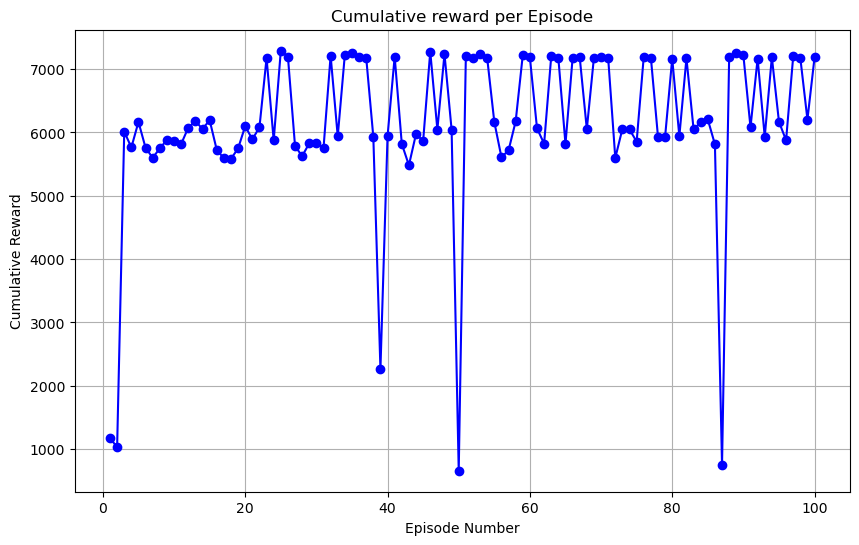

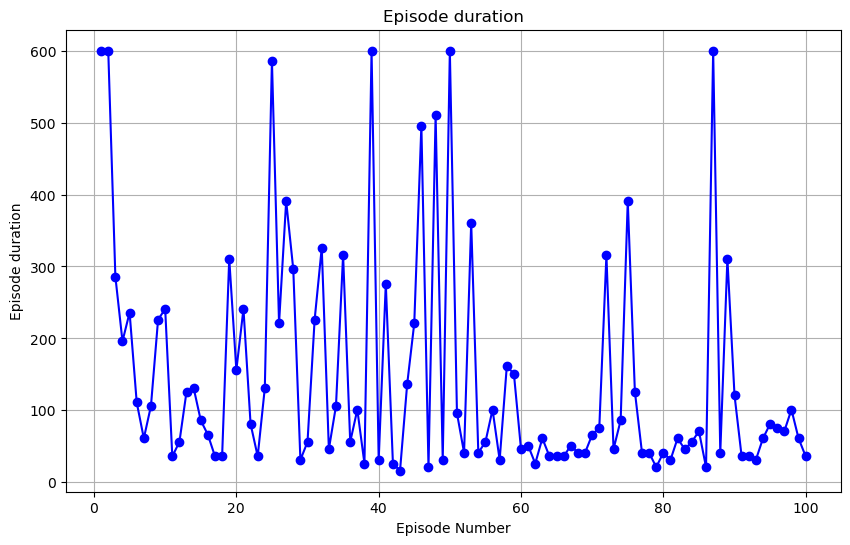

In [17]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

sum_list = []
ep_duration_list = []
for i, episode in enumerate(dql_with_defender["all_episodes_rewards"]):
        sum = np.sum(episode)
        sum_list.append(sum)
        ep_duration_list.append(len(episode))
        

episodes = list(range(1, len(sum_list) + 1))

plt.figure(figsize=(10, 6))
plt.plot(episodes, sum_list, marker='o', linestyle='-', color='b')
plt.title('Cumulative reward per Episode')
plt.xlabel('Episode Number')
plt.ylabel('Cumulative Reward')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(episodes, ep_duration_list, marker='o', linestyle='-', color='b')
plt.title('Episode duration')
plt.xlabel('Episode Number')
plt.ylabel('Episode duration')
plt.grid(True)
plt.show()

It can be observed that the algorithm becomes increasingly efficient over time. However, the cumulative reward is highly variable, which is likely due to the defender whose actions are completely random.

### 3.2 Agent test 

Now we will try our agent and see what he is doing at each action !

In [10]:
# initialize the environment
from cyberbattle.agents.baseline.agent_wrapper import ActionTrackingStateAugmentation, AgentWrapper, Verbosity


current_o = cyberbattlechain_defender.reset()
wrapped_env = AgentWrapper(cyberbattlechain_defender, ActionTrackingStateAugmentation(ep, current_o))
l = dql_with_defender['learner']
# Use the trained agent to run the steps one by one

max_steps = 20

# next action suggested by DQL agent
h = []
for i in range(max_steps):
    # run the suggested action
    _, next_action, _ = l.exploit(wrapped_env, current_o)
    # print(next_action)
    h.append((cyberbattlechain_defender.get_explored_network_node_properties_bitmap_as_numpy(current_o), next_action))
    if next_action is None:
        break
    current_o, _, _, _ = wrapped_env.step(next_action)
    cyberbattlechain_defender.render()

,status,properties,local_attacks,remote_attacks
id,,,,
start,owned,[],[ScanExplorerRecentFiles],[]
1_LinuxNode,discovered,NaN,None,"[ProbeLinux, ProbeWindows]"


,status,properties,local_attacks,remote_attacks
id,,,,
start,owned,[],[ScanExplorerRecentFiles],[]
1_LinuxNode,owned,"[MySql, Ubuntu, nginx/1.10.3]","[ScanExplorerRecentFiles, CrackKeepPassX, Sudo...","[ProbeLinux, ProbeWindows]"


,status,properties,local_attacks,remote_attacks
id,,,,
start,owned,[],[ScanExplorerRecentFiles],[]
1_LinuxNode,owned,"[MySql, Ubuntu, nginx/1.10.3]","[ScanExplorerRecentFiles, CrackKeepPassX, Sudo...","[ProbeLinux, ProbeWindows]"
2_WindowsNode,discovered,NaN,None,"[ProbeLinux, ProbeWindows]"


,status,properties,local_attacks,remote_attacks
id,,,,
start,owned,[],[ScanExplorerRecentFiles],[]
1_LinuxNode,owned,"[MySql, Ubuntu, nginx/1.10.3]","[ScanExplorerRecentFiles, CrackKeepPassX, Sudo...","[ProbeLinux, ProbeWindows]"
2_WindowsNode,owned,"[Windows, Win10, Win10Patched]","[ScanExplorerRecentFiles, CrackKeepPass, Crack...","[ProbeLinux, ProbeWindows]"


,status,properties,local_attacks,remote_attacks
id,,,,
start,owned,[],[ScanExplorerRecentFiles],[]
1_LinuxNode,owned,"[MySql, Ubuntu, nginx/1.10.3]","[ScanExplorerRecentFiles, CrackKeepPassX, Sudo...","[ProbeLinux, ProbeWindows]"
2_WindowsNode,owned,"[Windows, Win10, Win10Patched]","[ScanExplorerRecentFiles, CrackKeepPass, Crack...","[ProbeLinux, ProbeWindows]"
3_LinuxNode,discovered,NaN,None,"[ProbeLinux, ProbeWindows]"


,status,properties,local_attacks,remote_attacks
id,,,,
start,owned,[],[ScanExplorerRecentFiles],[]
1_LinuxNode,owned,"[MySql, Ubuntu, nginx/1.10.3]","[ScanExplorerRecentFiles, CrackKeepPassX, Sudo...","[ProbeLinux, ProbeWindows]"
2_WindowsNode,owned,"[Windows, Win10, Win10Patched]","[ScanExplorerRecentFiles, CrackKeepPass, Crack...","[ProbeLinux, ProbeWindows]"
3_LinuxNode,owned,"[MySql, Ubuntu, nginx/1.10.3]","[ScanExplorerRecentFiles, CrackKeepPassX, Sudo...","[ProbeLinux, ProbeWindows]"


,status,properties,local_attacks,remote_attacks
id,,,,
start,owned,[],[ScanExplorerRecentFiles],[]
1_LinuxNode,owned,"[MySql, Ubuntu, nginx/1.10.3]","[ScanExplorerRecentFiles, CrackKeepPassX, Sudo...","[ProbeLinux, ProbeWindows]"
2_WindowsNode,owned,"[Windows, Win10, Win10Patched]","[ScanExplorerRecentFiles, CrackKeepPass, Crack...","[ProbeLinux, ProbeWindows]"
3_LinuxNode,owned,"[MySql, Ubuntu, nginx/1.10.3]","[ScanExplorerRecentFiles, CrackKeepPassX, Sudo...","[ProbeLinux, ProbeWindows]"
4_WindowsNode,discovered,NaN,None,"[ProbeLinux, ProbeWindows]"


,status,properties,local_attacks,remote_attacks
id,,,,
start,owned,[],[ScanExplorerRecentFiles],[]
1_LinuxNode,owned,"[MySql, Ubuntu, nginx/1.10.3]","[ScanExplorerRecentFiles, CrackKeepPassX, Sudo...","[ProbeLinux, ProbeWindows]"
2_WindowsNode,owned,"[Windows, Win10, Win10Patched]","[ScanExplorerRecentFiles, CrackKeepPass, Crack...","[ProbeLinux, ProbeWindows]"
3_LinuxNode,owned,"[MySql, Ubuntu, nginx/1.10.3]","[ScanExplorerRecentFiles, CrackKeepPassX, Sudo...","[ProbeLinux, ProbeWindows]"
4_WindowsNode,owned,"[Windows, Win10, Win10Patched]","[ScanExplorerRecentFiles, CrackKeepPass, Crack...","[ProbeLinux, ProbeWindows]"


,status,properties,local_attacks,remote_attacks
id,,,,
start,owned,[],[ScanExplorerRecentFiles],[]
1_LinuxNode,owned,"[MySql, Ubuntu, nginx/1.10.3]","[ScanExplorerRecentFiles, CrackKeepPassX, Sudo...","[ProbeLinux, ProbeWindows]"
2_WindowsNode,owned,"[Windows, Win10, Win10Patched]","[ScanExplorerRecentFiles, CrackKeepPass, Crack...","[ProbeLinux, ProbeWindows]"
3_LinuxNode,owned,"[MySql, Ubuntu, nginx/1.10.3]","[ScanExplorerRecentFiles, CrackKeepPassX, Sudo...","[ProbeLinux, ProbeWindows]"
4_WindowsNode,owned,"[Windows, Win10, Win10Patched]","[ScanExplorerRecentFiles, CrackKeepPass, Crack...","[ProbeLinux, ProbeWindows]"
5_LinuxNode,discovered,NaN,None,"[ProbeLinux, ProbeWindows]"


,status,properties,local_attacks,remote_attacks
id,,,,
start,owned,[],[ScanExplorerRecentFiles],[]
1_LinuxNode,owned,"[MySql, Ubuntu, nginx/1.10.3]","[ScanExplorerRecentFiles, CrackKeepPassX, Sudo...","[ProbeLinux, ProbeWindows]"
2_WindowsNode,owned,"[Windows, Win10, Win10Patched]","[ScanExplorerRecentFiles, CrackKeepPass, Crack...","[ProbeLinux, ProbeWindows]"
3_LinuxNode,owned,"[MySql, Ubuntu, nginx/1.10.3]","[ScanExplorerRecentFiles, CrackKeepPassX, Sudo...","[ProbeLinux, ProbeWindows]"
4_WindowsNode,owned,"[Windows, Win10, Win10Patched]","[ScanExplorerRecentFiles, CrackKeepPass, Crack...","[ProbeLinux, ProbeWindows]"
5_LinuxNode,owned,"[MySql, Ubuntu, nginx/1.10.3]","[ScanExplorerRecentFiles, CrackKeepPassX, Sudo...","[ProbeLinux, ProbeWindows]"


,status,properties,local_attacks,remote_attacks
id,,,,
start,owned,[],[ScanExplorerRecentFiles],[]
1_LinuxNode,owned,"[MySql, Ubuntu, nginx/1.10.3]","[ScanExplorerRecentFiles, CrackKeepPassX, Sudo...","[ProbeLinux, ProbeWindows]"
2_WindowsNode,owned,"[Windows, Win10, Win10Patched]","[ScanExplorerRecentFiles, CrackKeepPass, Crack...","[ProbeLinux, ProbeWindows]"
3_LinuxNode,owned,"[MySql, Ubuntu, nginx/1.10.3]","[ScanExplorerRecentFiles, CrackKeepPassX, Sudo...","[ProbeLinux, ProbeWindows]"
4_WindowsNode,owned,"[Windows, Win10, Win10Patched]","[ScanExplorerRecentFiles, CrackKeepPass, Crack...","[ProbeLinux, ProbeWindows]"
5_LinuxNode,owned,"[MySql, Ubuntu, nginx/1.10.3]","[ScanExplorerRecentFiles, CrackKeepPassX, Sudo...","[ProbeLinux, ProbeWindows]"
6_WindowsNode,discovered,NaN,None,"[ProbeLinux, ProbeWindows]"


,status,properties,local_attacks,remote_attacks
id,,,,
start,owned,[],[ScanExplorerRecentFiles],[]
1_LinuxNode,owned,"[MySql, Ubuntu, nginx/1.10.3]","[ScanExplorerRecentFiles, CrackKeepPassX, Sudo...","[ProbeLinux, ProbeWindows]"
2_WindowsNode,owned,"[Windows, Win10, Win10Patched]","[ScanExplorerRecentFiles, CrackKeepPass, Crack...","[ProbeLinux, ProbeWindows]"
3_LinuxNode,owned,"[MySql, Ubuntu, nginx/1.10.3]","[ScanExplorerRecentFiles, CrackKeepPassX, Sudo...","[ProbeLinux, ProbeWindows]"
4_WindowsNode,owned,"[Windows, Win10, Win10Patched]","[ScanExplorerRecentFiles, CrackKeepPass, Crack...","[ProbeLinux, ProbeWindows]"
5_LinuxNode,owned,"[MySql, Ubuntu, nginx/1.10.3]","[ScanExplorerRecentFiles, CrackKeepPassX, Sudo...","[ProbeLinux, ProbeWindows]"
6_WindowsNode,owned,"[Windows, Win10, Win10Patched]","[ScanExplorerRecentFiles, CrackKeepPass, Crack...","[ProbeLinux, ProbeWindows]"


,status,properties,local_attacks,remote_attacks
id,,,,
start,owned,[],[ScanExplorerRecentFiles],[]
1_LinuxNode,owned,"[MySql, Ubuntu, nginx/1.10.3]","[ScanExplorerRecentFiles, CrackKeepPassX, Sudo...","[ProbeLinux, ProbeWindows]"
2_WindowsNode,owned,"[Windows, Win10, Win10Patched]","[ScanExplorerRecentFiles, CrackKeepPass, Crack...","[ProbeLinux, ProbeWindows]"
3_LinuxNode,owned,"[MySql, Ubuntu, nginx/1.10.3]","[ScanExplorerRecentFiles, CrackKeepPassX, Sudo...","[ProbeLinux, ProbeWindows]"
4_WindowsNode,owned,"[Windows, Win10, Win10Patched]","[ScanExplorerRecentFiles, CrackKeepPass, Crack...","[ProbeLinux, ProbeWindows]"
5_LinuxNode,owned,"[MySql, Ubuntu, nginx/1.10.3]","[ScanExplorerRecentFiles, CrackKeepPassX, Sudo...","[ProbeLinux, ProbeWindows]"
6_WindowsNode,owned,"[Windows, Win10, Win10Patched]","[ScanExplorerRecentFiles, CrackKeepPass, Crack...","[ProbeLinux, ProbeWindows]"
7_LinuxNode,discovered,NaN,None,"[ProbeLinux, ProbeWindows]"


,status,properties,local_attacks,remote_attacks
id,,,,
start,owned,[],[ScanExplorerRecentFiles],[]
1_LinuxNode,owned,"[MySql, Ubuntu, nginx/1.10.3]","[ScanExplorerRecentFiles, CrackKeepPassX, Sudo...","[ProbeLinux, ProbeWindows]"
2_WindowsNode,owned,"[Windows, Win10, Win10Patched]","[ScanExplorerRecentFiles, CrackKeepPass, Crack...","[ProbeLinux, ProbeWindows]"
3_LinuxNode,owned,"[MySql, Ubuntu, nginx/1.10.3]","[ScanExplorerRecentFiles, CrackKeepPassX, Sudo...","[ProbeLinux, ProbeWindows]"
4_WindowsNode,owned,"[Windows, Win10, Win10Patched]","[ScanExplorerRecentFiles, CrackKeepPass, Crack...","[ProbeLinux, ProbeWindows]"
5_LinuxNode,owned,"[MySql, Ubuntu, nginx/1.10.3]","[ScanExplorerRecentFiles, CrackKeepPassX, Sudo...","[ProbeLinux, ProbeWindows]"
6_WindowsNode,owned,"[Windows, Win10, Win10Patched]","[ScanExplorerRecentFiles, CrackKeepPass, Crack...","[ProbeLinux, ProbeWindows]"
7_LinuxNode,owned,"[MySql, Ubuntu, nginx/1.10.3]","[ScanExplorerRecentFiles, CrackKeepPassX, Sudo...","[ProbeLinux, ProbeWindows]"


,status,properties,local_attacks,remote_attacks
id,,,,
start,owned,[],[ScanExplorerRecentFiles],[]
1_LinuxNode,owned,"[MySql, Ubuntu, nginx/1.10.3]","[ScanExplorerRecentFiles, CrackKeepPassX, Sudo...","[ProbeLinux, ProbeWindows]"
2_WindowsNode,owned,"[Windows, Win10, Win10Patched]","[ScanExplorerRecentFiles, CrackKeepPass, Crack...","[ProbeLinux, ProbeWindows]"
3_LinuxNode,owned,"[MySql, Ubuntu, nginx/1.10.3]","[ScanExplorerRecentFiles, CrackKeepPassX, Sudo...","[ProbeLinux, ProbeWindows]"
4_WindowsNode,owned,"[Windows, Win10, Win10Patched]","[ScanExplorerRecentFiles, CrackKeepPass, Crack...","[ProbeLinux, ProbeWindows]"
5_LinuxNode,owned,"[MySql, Ubuntu, nginx/1.10.3]","[ScanExplorerRecentFiles, CrackKeepPassX, Sudo...","[ProbeLinux, ProbeWindows]"
6_WindowsNode,owned,"[Windows, Win10, Win10Patched]","[ScanExplorerRecentFiles, CrackKeepPass, Crack...","[ProbeLinux, ProbeWindows]"
7_LinuxNode,owned,"[MySql, Ubuntu, nginx/1.10.3]","[ScanExplorerRecentFiles, CrackKeepPassX, Sudo...","[ProbeLinux, ProbeWindows]"
8_WindowsNode,discovered,NaN,None,"[ProbeLinux, ProbeWindows]"


,status,properties,local_attacks,remote_attacks
id,,,,
start,owned,[],[ScanExplorerRecentFiles],[]
1_LinuxNode,owned,"[MySql, Ubuntu, nginx/1.10.3]","[ScanExplorerRecentFiles, CrackKeepPassX, Sudo...","[ProbeLinux, ProbeWindows]"
2_WindowsNode,owned,"[Windows, Win10, Win10Patched]","[ScanExplorerRecentFiles, CrackKeepPass, Crack...","[ProbeLinux, ProbeWindows]"
3_LinuxNode,owned,"[MySql, Ubuntu, nginx/1.10.3]","[ScanExplorerRecentFiles, CrackKeepPassX, Sudo...","[ProbeLinux, ProbeWindows]"
4_WindowsNode,owned,"[Windows, Win10, Win10Patched]","[ScanExplorerRecentFiles, CrackKeepPass, Crack...","[ProbeLinux, ProbeWindows]"
5_LinuxNode,owned,"[MySql, Ubuntu, nginx/1.10.3]","[ScanExplorerRecentFiles, CrackKeepPassX, Sudo...","[ProbeLinux, ProbeWindows]"
6_WindowsNode,owned,"[Windows, Win10, Win10Patched]","[ScanExplorerRecentFiles, CrackKeepPass, Crack...","[ProbeLinux, ProbeWindows]"
7_LinuxNode,owned,"[MySql, Ubuntu, nginx/1.10.3]","[ScanExplorerRecentFiles, CrackKeepPassX, Sudo...","[ProbeLinux, ProbeWindows]"
8_WindowsNode,owned,"[Windows, Win10, Win10Patched]","[ScanExplorerRecentFiles, CrackKeepPass, Crack...","[ProbeLinux, ProbeWindows]"


,status,properties,local_attacks,remote_attacks
id,,,,
start,owned,[],[ScanExplorerRecentFiles],[]
1_LinuxNode,owned,"[MySql, Ubuntu, nginx/1.10.3]","[ScanExplorerRecentFiles, CrackKeepPassX, Sudo...","[ProbeLinux, ProbeWindows]"
2_WindowsNode,owned,"[Windows, Win10, Win10Patched]","[ScanExplorerRecentFiles, CrackKeepPass, Crack...","[ProbeLinux, ProbeWindows]"
3_LinuxNode,owned,"[MySql, Ubuntu, nginx/1.10.3]","[ScanExplorerRecentFiles, CrackKeepPassX, Sudo...","[ProbeLinux, ProbeWindows]"
4_WindowsNode,owned,"[Windows, Win10, Win10Patched]","[ScanExplorerRecentFiles, CrackKeepPass, Crack...","[ProbeLinux, ProbeWindows]"
5_LinuxNode,owned,"[MySql, Ubuntu, nginx/1.10.3]","[ScanExplorerRecentFiles, CrackKeepPassX, Sudo...","[ProbeLinux, ProbeWindows]"
6_WindowsNode,owned,"[Windows, Win10, Win10Patched]","[ScanExplorerRecentFiles, CrackKeepPass, Crack...","[ProbeLinux, ProbeWindows]"
7_LinuxNode,owned,"[MySql, Ubuntu, nginx/1.10.3]","[ScanExplorerRecentFiles, CrackKeepPassX, Sudo...","[ProbeLinux, ProbeWindows]"
8_WindowsNode,owned,"[Windows, Win10, Win10Patched]","[ScanExplorerRecentFiles, CrackKeepPass, Crack...","[ProbeLinux, ProbeWindows]"


,status,properties,local_attacks,remote_attacks
id,,,,
start,owned,[],[ScanExplorerRecentFiles],[]
1_LinuxNode,owned,"[MySql, Ubuntu, nginx/1.10.3]","[ScanExplorerRecentFiles, CrackKeepPassX, Sudo...","[ProbeLinux, ProbeWindows]"
2_WindowsNode,owned,"[Windows, Win10, Win10Patched]","[ScanExplorerRecentFiles, CrackKeepPass, Crack...","[ProbeLinux, ProbeWindows]"
3_LinuxNode,owned,"[MySql, Ubuntu, nginx/1.10.3]","[ScanExplorerRecentFiles, CrackKeepPassX, Sudo...","[ProbeLinux, ProbeWindows]"
4_WindowsNode,owned,"[Windows, Win10, Win10Patched]","[ScanExplorerRecentFiles, CrackKeepPass, Crack...","[ProbeLinux, ProbeWindows]"
5_LinuxNode,owned,"[MySql, Ubuntu, nginx/1.10.3]","[ScanExplorerRecentFiles, CrackKeepPassX, Sudo...","[ProbeLinux, ProbeWindows]"
6_WindowsNode,owned,"[Windows, Win10, Win10Patched]","[ScanExplorerRecentFiles, CrackKeepPass, Crack...","[ProbeLinux, ProbeWindows]"
7_LinuxNode,owned,"[MySql, Ubuntu, nginx/1.10.3]","[ScanExplorerRecentFiles, CrackKeepPassX, Sudo...","[ProbeLinux, ProbeWindows]"
8_WindowsNode,owned,"[Windows, Win10, Win10Patched]","[ScanExplorerRecentFiles, CrackKeepPass, Crack...","[ProbeLinux, ProbeWindows]"


,status,properties,local_attacks,remote_attacks
id,,,,
start,owned,[],[ScanExplorerRecentFiles],[]
1_LinuxNode,owned,"[MySql, Ubuntu, nginx/1.10.3]","[ScanExplorerRecentFiles, CrackKeepPassX, Sudo...","[ProbeLinux, ProbeWindows]"
2_WindowsNode,owned,"[Windows, Win10, Win10Patched]","[ScanExplorerRecentFiles, CrackKeepPass, Crack...","[ProbeLinux, ProbeWindows]"
3_LinuxNode,owned,"[MySql, Ubuntu, nginx/1.10.3]","[ScanExplorerRecentFiles, CrackKeepPassX, Sudo...","[ProbeLinux, ProbeWindows]"
4_WindowsNode,owned,"[Windows, Win10, Win10Patched]","[ScanExplorerRecentFiles, CrackKeepPass, Crack...","[ProbeLinux, ProbeWindows]"
5_LinuxNode,owned,"[MySql, Ubuntu, nginx/1.10.3]","[ScanExplorerRecentFiles, CrackKeepPassX, Sudo...","[ProbeLinux, ProbeWindows]"
6_WindowsNode,owned,"[Windows, Win10, Win10Patched]","[ScanExplorerRecentFiles, CrackKeepPass, Crack...","[ProbeLinux, ProbeWindows]"
7_LinuxNode,owned,"[MySql, Ubuntu, nginx/1.10.3]","[ScanExplorerRecentFiles, CrackKeepPassX, Sudo...","[ProbeLinux, ProbeWindows]"
8_WindowsNode,owned,"[Windows, Win10, Win10Patched]","[ScanExplorerRecentFiles, CrackKeepPass, Crack...","[ProbeLinux, ProbeWindows]"


,status,properties,local_attacks,remote_attacks
id,,,,
start,owned,[],[ScanExplorerRecentFiles],[]
1_LinuxNode,owned,"[MySql, Ubuntu, nginx/1.10.3]","[ScanExplorerRecentFiles, CrackKeepPassX, Sudo...","[ProbeLinux, ProbeWindows]"
2_WindowsNode,owned,"[Windows, Win10, Win10Patched]","[ScanExplorerRecentFiles, CrackKeepPass, Crack...","[ProbeLinux, ProbeWindows]"
3_LinuxNode,owned,"[MySql, Ubuntu, nginx/1.10.3]","[ScanExplorerRecentFiles, CrackKeepPassX, Sudo...","[ProbeLinux, ProbeWindows]"
4_WindowsNode,owned,"[Windows, Win10, Win10Patched]","[ScanExplorerRecentFiles, CrackKeepPass, Crack...","[ProbeLinux, ProbeWindows]"
5_LinuxNode,owned,"[MySql, Ubuntu, nginx/1.10.3]","[ScanExplorerRecentFiles, CrackKeepPassX, Sudo...","[ProbeLinux, ProbeWindows]"
6_WindowsNode,owned,"[Windows, Win10, Win10Patched]","[ScanExplorerRecentFiles, CrackKeepPass, Crack...","[ProbeLinux, ProbeWindows]"
7_LinuxNode,owned,"[MySql, Ubuntu, nginx/1.10.3]","[ScanExplorerRecentFiles, CrackKeepPassX, Sudo...","[ProbeLinux, ProbeWindows]"
8_WindowsNode,owned,"[Windows, Win10, Win10Patched]","[ScanExplorerRecentFiles, CrackKeepPass, Crack...","[ProbeLinux, ProbeWindows]"
